In [1]:
#Step 0 — Setup
import sys
from pathlib import Path

# Adjust if needed — point to your repo
REPO_DIR = Path("/Users/ywxiu/jasp-multimodal-rag")
sys.path.append(str(REPO_DIR))

# import data
import pandas as pd
import numpy as np

# Load the file
path = "../data/evaluation/retrieval_evaluation.csv"

df_eval = pd.read_csv(path)

# data description
print("Shape (rows, columns):", df_eval.shape)
print("data type:", df_eval.dtypes)




Shape (rows, columns): (1600, 9)
data type: QID                    int64
Question              object
Difficulty Level      object
Gold Standard Set     object
Retrieval Mode        object
Rank                   int64
Retrieved Doc         object
Relevance              int64
Notes                float64
dtype: object


#### These metrics provide a complementary and robust evaluation of retrieval performance:
    Success@k: Does retrieval succeed at all?

    MRR@k:How quickly does it succeed?

    nDCG@k:How well are documents ordered?

    Precision@k (gold):How noisy is the retrieved context?

    Recall@k (gold):How much of the annotated gold is covered?




| Metric                 | What it measures                                                              | How it is calculated                                                                                                                    | Why it is needed                                                                                                                                              | Limitations                                                                                                               | How to interpret results                                                                                                                                                     |
| ---------------------- | ----------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Success@k**  -grounding success      | Whether at least one relevant document appears in the top-k retrieved results | Binary indicator: equals 1 if any retrieved document among the top-k has relevance ≥ 1, otherwise 0                                     | Reflects the *minimum requirement* for successful grounding in RAG systems; the LLM only needs one relevant document to potentially generate a correct answer | Ignores ranking among relevant documents and does not penalize additional non-relevant documents                          | {0, 1}. Higher values indicate a higher probability that the retriever provides at least one useful document; differences should be interpreted as changes in grounding success rate |
| **MRR@k**   -early relevance      | How early the first relevant document appears in the ranked list              | Reciprocal of the rank of the first relevant document (rel ≥ 1); equals 0 if no relevant document is retrieved                          | Captures ranking quality with respect to the *first useful document*, which is critical for limited-context LLM prompting                                     | Ignores all relevant documents after the first; does not measure overall precision                                        | {0, 0.2, 0.4, 0.6, 0.8, 1.0}.Higher values indicate that relevant documents are retrieved earlier; small differences can imply meaningful latency or usability improvements                               |
| **nDCG@k**   -ranking quality  | Overall ranking quality with graded relevance                                 | DCG@k uses gain (2^{rel}-1) and logarithmic rank discount; normalized by the ideal DCG obtained by reordering the same relevance scores | Exploits full graded relevance information (0,1,2); rewards highly relevant documents appearing early in the ranking                                          | Depends on relevance judgments within the retrieved set; not a measure of absolute recall against the full knowledge base | [0, 1].Higher values indicate better ordering of relevant documents; comparisons are meaningful across retrieval modes under the same evaluation protocol                           |
| **Precision@k (gold)**   -context precision | Proportion of retrieved documents that match the gold standard set            | Number of retrieved documents in the top-k that appear in the gold set divided by k                                                     | Provides a reference measure of how “clean” or focused the retrieved context is                                                                               |  For queries with only one annotated gold document and k=5, the maximum achievable precision is 0.2, even under perfect retrieval.       |{0, 0.2, 0.4, 0.6, 0.8, 1.0}. Higher values indicate fewer irrelevant documents among retrieved results, but absolute values should be interpreted cautiously                                              |
| **Recall@k (gold)**   -completeness  | Coverage of the gold standard set within the top-k retrieved results          | Number of retrieved gold documents divided by the size of the gold standard set                                                         | Gives transparency about overlap with annotated gold documents                                                                                                | Not reliable as a true recall measure due to incomplete gold standard                                   | [0, 1].Useful only for relative comparison; low values do not imply poor retrieval in an absolute sense                                                                             |


In [2]:
import numpy as np
import pandas as pd

df_eval = df_eval.copy()
df_eval["Rank"] = pd.to_numeric(df_eval["Rank"], errors="coerce")
df_eval["Relevance"] = pd.to_numeric(df_eval["Relevance"], errors="coerce").fillna(0).astype(int)
df_eval["Retrieval Mode"] = df_eval["Retrieval Mode"].astype(str).str.strip()
df_eval["Retrieved Doc"] = df_eval["Retrieved Doc"].astype(str).str.strip()

def parse_gold_set(x) -> list[str]:
    if pd.isna(x):
        return []
    s = str(x).strip().strip('"').strip("'")
    if not s:
        return []
    return [p.strip() for p in s.split(",") if p.strip()]

def dcg_from_rels(rels: np.ndarray) -> float:
    if len(rels) == 0:
        return 0.0
    gains = (2 ** rels) - 1
    discounts = np.log2(np.arange(2, len(rels) + 2))
    return float(np.sum(gains / discounts))

def compute_metrics_one_group(g: pd.DataFrame, k: int = 5, rel_threshold: int = 1) -> pd.Series:
    g = g.sort_values("Rank")
    gk = g.head(k)

    # ---- carry query-level info ----
    qid = g["QID"].iloc[0]
    question = g["Question"].iloc[0] if "Question" in g.columns else None
    difficulty = g["Difficulty Level"].iloc[0]
    mode = g["Retrieval Mode"].iloc[0]
    gold_raw = g["Gold Standard Set"].iloc[0] if "Gold Standard Set" in g.columns else None

    # ---- graded / ranked metrics ----
    rels = gk["Relevance"].to_numpy(dtype=int)
    is_rel = (rels >= rel_threshold).astype(int)

    # Success@k measures whether at least one relevant document appears in the top-k results.
    # In a Retrieval-Augmented Generation (RAG) setting, this reflects the minimum requirement for successful grounding: 
    # the language model only needs one relevant document to potentially generate a correct answer.
    success_k = int(is_rel.sum() > 0)

    #Mean Reciprocal Rank (MRR@k)
    # MRR@k measures how early the first relevant document appears in the ranked list.
    # Higher MRR means relevant information is surfaced sooner 
    # It mesures Ranking-sensitive,but ignores additional relevant documents after the first one
    mrr_k = 1.0 / (int(np.argmax(is_rel == 1)) + 1) if success_k else 0.0


    # nDCG@k (Normalized Discounted Cumulative Gain)
    # first:Discounted Cumulative Gain (DCG)
    dcg_k = dcg_from_rels(rels)
    #Then, Ideal DCG (IDCG) is computed by sorting the same relevance scores in decreasing order.
    idcg_k = dcg_from_rels(np.sort(rels)[::-1])
    # last,nDCG@k evaluates ranking quality with graded relevance, 
    # rewarding:Highly relevant documents Appearing early in the rankingThe logarithmic discount, penalizes lower-ranked documents
    ndcg_k = float(dcg_k / idcg_k) if idcg_k > 0 else 0.0

    # ---- precision/recall ----
    gold_set = set(parse_gold_set(gold_raw))
    retrieved_set = set(gk["Retrieved Doc"].tolist())
    hits_count = len(retrieved_set & gold_set)


    # Precision@k (Gold-reference)
    # This metric measures how many of the retrieved documents belong to the manually constructed gold set.
    # limitation: Sensitive to fixed k,Coarse-grained when k is small,Penalizes retrieving extra non-relevant documents even when one relevant document is sufficient
    precision_k_goldref = hits_count / k    

    # Recall@k measures the fraction of gold-standard documents retrieved within the top-k results.
    recall_k_goldref = hits_count / len(gold_set) if len(gold_set) > 0 else np.nan

    assert hits_count <= len(gold_set), "hits_count exceeds gold size"
    assert hits_count <= k, "hits_count exceeds k"

    return pd.Series({
        # query-level fields (what you asked for)
        "QID": qid,
        "Question": question,
        "Difficulty Level": difficulty,
        "Retrieval Mode": mode,
        "Gold Standard Set": gold_raw,

        # settings
        "k": k,

        # main metrics
        "success@k": success_k,
        "mrr@k": mrr_k,
        "ndcg@k": ndcg_k,

        # relevance-based precision (binary rel>=1)
        "precision@k_rel>=1": float(is_rel.mean()) if len(is_rel) > 0 else np.nan,

        # gold-reference (for reference)
        "precision@k_goldref": precision_k_goldref,
        "recall@k_goldref": recall_k_goldref,
        "gold_size": int(len(gold_set)),
        "hits_in_gold_topk": int(hits_count),
    })

K = 4
metrics_df = (
    df_eval
    .dropna(subset=["QID", "Difficulty Level", "Retrieval Mode", "Rank"])
    .groupby(["QID", "Difficulty Level", "Retrieval Mode"], as_index=False)
    .apply(lambda g: compute_metrics_one_group(g, k=K, rel_threshold=1))
    .reset_index(drop=True)
)


# Now metrics_df includes the question content
print(metrics_df[["QID","Question","Difficulty Level","Retrieval Mode","success@k","mrr@k","ndcg@k",
                  "precision@k_rel>=1","precision@k_goldref","recall@k_goldref"]].head(12))


    QID                                           Question Difficulty Level  \
0     1       How do I open a dataset and view it in JASP?             easy   
1     1       How do I open a dataset and view it in JASP?             easy   
2     1       How do I open a dataset and view it in JASP?             easy   
3     1       How do I open a dataset and view it in JASP?             easy   
4     2  How can I save or export a JASP data file in J...             easy   
5     2  How can I save or export a JASP data file in J...             easy   
6     2  How can I save or export a JASP data file in J...             easy   
7     2  How can I save or export a JASP data file in J...             easy   
8     3         How to set up results preferences in JASP?             easy   
9     3         How to set up results preferences in JASP?             easy   
10    3         How to set up results preferences in JASP?             easy   
11    3         How to set up results preferences in

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3272832779.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: compute_metrics_one_group(g, k=K, rel_threshold=1))


In [30]:
# metric sanity check function 
# It checks: missing values, value ranges,impossible values,expected discreteness,duplicate-related issues,basic descriptive stats
import numpy as np
import pandas as pd

def check_metrics_df(metrics_df, k=5, verbose=True):
    """
    Sanity checks for retrieval evaluation metrics.
    Designed for Success@k, MRR@k, nDCG@k, Precision@k (gold), Recall@k (gold).
    """

    report = {}

    def _print(msg):
        if verbose:
            print(msg)

    _print("===== METRICS DF SANITY CHECK =====\n")

    # -------------------------------------------------
    # 1. Required columns
    # -------------------------------------------------
    required_cols = [
        "QID",
        "Difficulty Level",
        "Retrieval Mode",
        "success@k",
        "mrr@k",
        "ndcg@k",
        "precision@k_goldref",
        "recall@k_goldref",
        "gold_size",
    ]

    missing_cols = [c for c in required_cols if c not in metrics_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    _print("✓ Required columns present")

    # -------------------------------------------------
    # 2. Missing values
    # -------------------------------------------------
    _print("\n--- Missing values ---")
    na_summary = metrics_df[required_cols].isna().mean().sort_values(ascending=False)
    report["missing_fraction"] = na_summary
    _print(na_summary)

    # -------------------------------------------------
    # 3. Range checks (hard constraints)
    # -------------------------------------------------
    _print("\n--- Range checks ---")

    def check_range(col, low, high):
        bad = metrics_df[(metrics_df[col] < low) | (metrics_df[col] > high)]
        _print(f"{col}: expected [{low},{high}] → bad rows: {len(bad)}")
        return bad

    bad_success = check_range("success@k", 0, 1)
    bad_mrr = check_range("mrr@k", 0, 1)
    bad_ndcg = check_range("ndcg@k", 0, 1)
    bad_precision = check_range("precision@k_goldref", 0, 1)
    bad_recall = check_range("recall@k_goldref", 0, 1)

    report["range_violations"] = {
        "success": len(bad_success),
        "mrr": len(bad_mrr),
        "ndcg": len(bad_ndcg),
        "precision": len(bad_precision),
        "recall": len(bad_recall),
    }

    # -------------------------------------------------
    # 4. Expected value sets (discreteness)
    # -------------------------------------------------
    _print("\n--- Discreteness checks ---")

    expected_precision_vals = {i / k for i in range(k + 1)}
    precision_vals = set(metrics_df["precision@k_goldref"].dropna().unique())

    unexpected_prec = precision_vals - expected_precision_vals
    _print(f"Precision@k unique values: {sorted(precision_vals)}")
    _print(f"Unexpected precision values: {unexpected_prec}")

    expected_mrr_vals = {0} | {1 / i for i in range(1, k + 1)}
    mrr_vals = set(metrics_df["mrr@k"].dropna().unique())
    unexpected_mrr = mrr_vals - expected_mrr_vals
    _print(f"Unexpected MRR values: {unexpected_mrr}")

    report["unexpected_values"] = {
        "precision": unexpected_prec,
        "mrr": unexpected_mrr,
    }

    # -------------------------------------------------
    # 5. Gold-size consistency
    # -------------------------------------------------
    _print("\n--- Gold-size consistency ---")

    bad_gold = metrics_df[metrics_df["gold_size"] <= 0]
    _print(f"Gold size <= 0 rows: {len(bad_gold)}")

    recall_gt1 = metrics_df[metrics_df["recall@k_goldref"] > 1]
    _print(f"Recall > 1 rows: {len(recall_gt1)}")

    report["gold_issues"] = {
        "gold_size_le_0": len(bad_gold),
        "recall_gt_1": len(recall_gt1),
    }

    # -------------------------------------------------
    # 6. Duplicate retrieval sanity (query-level)
    # -------------------------------------------------
    _print("\n--- Duplicate diagnostics (query-level) ---")

    dup_counts = (
        metrics_df
        .groupby(["QID", "Retrieval Mode"])
        .size()
        .describe()
    )
    _print("Rows per (QID, Mode):")
    _print(dup_counts)

    report["rows_per_query_mode"] = dup_counts

    # -------------------------------------------------
    # 7. Metric relationships (logical checks)
    # -------------------------------------------------
    _print("\n--- Logical relationship checks ---")

    # Success@k should be 1 iff recall > 0
    mismatch_success = metrics_df[
        (metrics_df["success@k"] == 0) & (metrics_df["recall@k_goldref"] > 0)
    ]
    _print(f"Success=0 but Recall>0 rows: {len(mismatch_success)}")

    # If MRR > 0, Success must be 1
    mismatch_mrr = metrics_df[
        (metrics_df["mrr@k"] > 0) & (metrics_df["success@k"] == 0)
    ]
    _print(f"MRR>0 but Success=0 rows: {len(mismatch_mrr)}")

    report["logical_mismatches"] = {
        "success_vs_recall": len(mismatch_success),
        "mrr_vs_success": len(mismatch_mrr),
    }

    # -------------------------------------------------
    # 8. Descriptive stats (quick scan)
    # -------------------------------------------------
    _print("\n--- Descriptive statistics ---")
    desc = metrics_df[
        ["success@k", "mrr@k", "ndcg@k", "precision@k_rel>=1", "recall@k_goldref"]
    ].describe()
    _print(desc)

    report["describe"] = desc

    _print("\n===== CHECK COMPLETE =====")

    return report

report = check_metrics_df(metrics_df, k=3)



===== METRICS DF SANITY CHECK =====

✓ Required columns present

--- Missing values ---
QID                    0.0
Difficulty Level       0.0
Retrieval Mode         0.0
success@k              0.0
mrr@k                  0.0
ndcg@k                 0.0
precision@k_goldref    0.0
recall@k_goldref       0.0
gold_size              0.0
dtype: float64

--- Range checks ---
success@k: expected [0,1] → bad rows: 0
mrr@k: expected [0,1] → bad rows: 0
ndcg@k: expected [0,1] → bad rows: 0
precision@k_goldref: expected [0,1] → bad rows: 0
recall@k_goldref: expected [0,1] → bad rows: 0

--- Discreteness checks ---
Precision@k unique values: [np.float64(0.0), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(1.0)]
Unexpected precision values: {np.float64(0.25), np.float64(0.5), np.float64(0.75)}
Unexpected MRR values: {np.float64(0.25)}

--- Gold-size consistency ---
Gold size <= 0 rows: 0
Recall > 1 rows: 0

--- Duplicate diagnostics (query-level) ---
Rows per (QID, Mode):
count    320.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3285563557.py:118: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [31]:
import pandas as pd
import numpy as np

def general_evaluation_table(metrics_df):
    rows = []

    metrics = {
        "Success@k": "success@k",
        "MRR@k": "mrr@k",
        "nDCG@k": "ndcg@k",
        "precision@k_rel>=1": "precision@k_rel>=1",
        "Recall@k (gold)": "recall@k_goldref",
    }

    for name, col in metrics.items():
        x = metrics_df[col].dropna().values

        rows.append({
            "Metric": name,
            "N": len(x),
            "Mean": np.mean(x),
            "Std": np.std(x, ddof=1),
            "Min": np.min(x),
            "Q25": np.quantile(x, 0.25),
            "Median": np.median(x),
            "Q75": np.quantile(x, 0.75),
            "Max": np.max(x),
        })

    table = pd.DataFrame(rows)

    # Optional: rounding for presentation
    table = table.round({
        "Mean": 3,
        "Std": 3,
        "Min": 3,
        "Q25": 3,
        "Median": 3,
        "Q75": 3,
        "Max": 3,
    })

    return table


general_eval_table = general_evaluation_table(metrics_df)
general_eval_table


,Metric,N,Mean,Std,Min,Q25,Median,Q75,Max
0,Success@k,320,0.891,0.313,0.0,1.00,1.000,1.00,1.0
1,MRR@k,320,0.780,0.359,0.0,0.50,1.000,1.00,1.0
2,nDCG@k,320,0.784,0.321,0.0,0.64,0.955,1.00,1.0
3,precision@k_rel>=1,320,0.541,0.316,0.0,0.25,0.500,0.75,1.0
4,Recall@k (gold),320,0.650,0.370,0.0,0.50,0.667,1.00,1.0


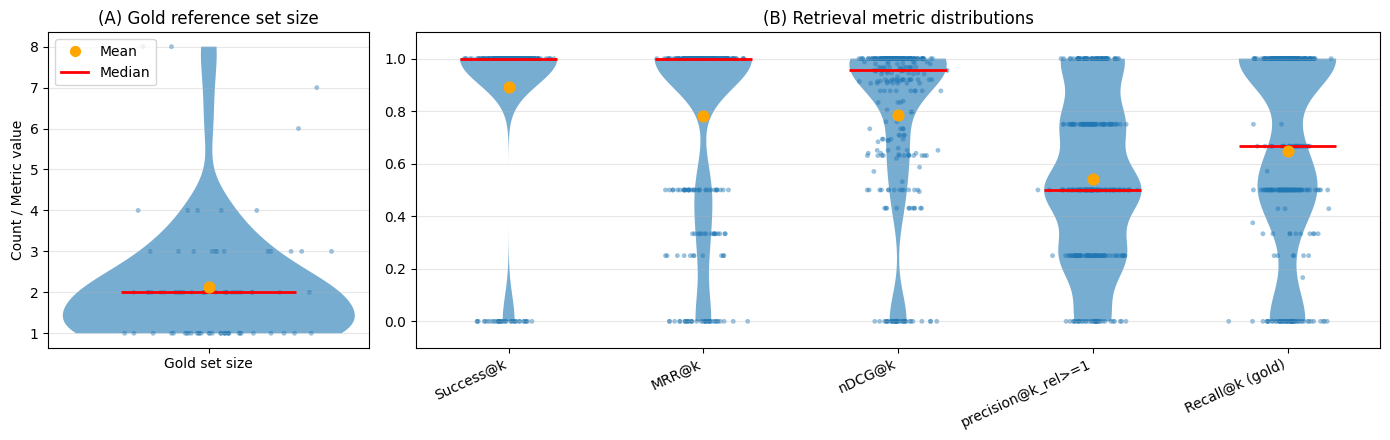

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Data
# -----------------------------
# Gold size is query-level → collapse to unique queries
gold_sizes = (
    metrics_df
    .groupby("QID", as_index=False)
    .agg(gold_size=("gold_size", "first"))["gold_size"]
    .values
)

metric_cols = [
    ("Success@k", "success@k"),
    ("MRR@k", "mrr@k"),
    ("nDCG@k", "ndcg@k"),
    ("precision@k_rel>=1", "precision@k_rel>=1"),
    ("Recall@k (gold)", "recall@k_goldref"),
]

metric_data = [metrics_df[col].dropna().values for _, col in metric_cols]
metric_labels = [name for name, _ in metric_cols]

DOT_COLOR = "tab:blue"
jitter = 0.08

# -----------------------------
# Figure with two panels
# -----------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 4.5),
    gridspec_kw={"width_ratios": [1, 3]},
    sharey=False
)

# ===== (A) Gold set size =====
ax = axes[0]

vp = ax.violinplot(
    [gold_sizes],
    showmeans=False,
    showmedians=False,
    showextrema=False
)
for body in vp["bodies"]:
    body.set_alpha(0.6)

# dots
x_j = np.random.normal(1, jitter, size=len(gold_sizes))
ax.scatter(x_j, gold_sizes, s=12, color=DOT_COLOR, alpha=0.45, edgecolors="none")

# mean + median
ax.scatter(1, np.mean(gold_sizes), s=60, color="orange", zorder=3, label="Mean")
ax.hlines(
    np.median(gold_sizes),
    0.85, 1.15,
    color="red",
    linewidth=2,
    label="Median"
)

ax.set_xticks([1])
ax.set_xticklabels(["Gold set size"])
ax.set_ylabel("Count / Metric value")
ax.set_title("(A) Gold reference set size")
ax.grid(axis="y", alpha=0.3)

# ===== (B) Metrics =====
ax = axes[1]

vp = ax.violinplot(
    metric_data,
    showmeans=False,
    showmedians=False,
    showextrema=False
)
for body in vp["bodies"]:
    body.set_alpha(0.6)

# dots
for i, y in enumerate(metric_data, start=1):
    x_j = np.random.normal(i, jitter, size=len(y))
    ax.scatter(x_j, y, s=12, color=DOT_COLOR, alpha=0.45, edgecolors="none")

# mean + median
means = [np.mean(y) for y in metric_data]
medians = [np.median(y) for y in metric_data]
x = np.arange(1, len(metric_data) + 1)

ax.scatter(x, means, s=60, color="orange", zorder=3)
ax.hlines(medians, x - 0.25, x + 0.25, color="red", linewidth=2)

ax.set_xticks(x)
ax.set_xticklabels(metric_labels, rotation=25, ha="right")
ax.set_ylim(-0.1, 1.1)
ax.set_title("(B) Retrieval metric distributions")
ax.grid(axis="y", alpha=0.3)

# Shared legend
handles = [
    plt.Line2D([0], [0], marker="o", color="orange", linestyle="None", markersize=7, label="Mean"),
    plt.Line2D([0], [0], color="red", linewidth=2, label="Median"),
]
axes[0].legend(handles=handles, loc="upper left")

plt.tight_layout()
plt.show()


In [6]:
# optional: save
out_path = f"metrics.csv"
metrics_df.to_csv(out_path, index=False)

print("Saved to:", out_path)

Saved to: metrics.csv


In [7]:
metrics_df[metrics_df["QID"].isin([14, 114])].sort_values(["QID", "Retrieval Mode"])


,QID,Question,Difficulty Level,Retrieval Mode,Gold Standard Set,k,success@k,mrr@k,ndcg@k,precision@k_rel>=1,precision@k_goldref,recall@k_goldref,gold_size,hits_in_gold_topk
52,14,What output does JASP provide for correlation ...,easy,BM25,"pdf_73,pdf_74,pdf_75,pdf_76.pdf_77",4,0,0.0,0.000000,0.00,0.0,0.000000,4,0
53,14,What output does JASP provide for correlation ...,easy,bm_vector_fusion,"pdf_73,pdf_74,pdf_75,pdf_76.pdf_77",4,0,0.0,0.000000,0.00,0.0,0.000000,4,0
54,14,What output does JASP provide for correlation ...,easy,bm_vector_fusion_rerank,"pdf_73,pdf_74,pdf_75,pdf_76.pdf_77",4,0,0.0,0.000000,0.00,0.0,0.000000,4,0
55,14,What output does JASP provide for correlation ...,easy,vector,"pdf_73,pdf_74,pdf_75,pdf_76.pdf_77",4,0,0.0,0.000000,0.00,0.0,0.000000,4,0
212,114,My data is continuous but violate normality as...,difficult,BM25,"pdf_77,md_jaspRegression__CorrelationBayesian,...",4,1,1.0,0.967468,0.75,0.0,0.000000,3,0
213,114,My data is continuous but violate normality as...,difficult,bm_vector_fusion,"pdf_77,md_jaspRegression__CorrelationBayesian,...",4,1,1.0,0.759506,1.00,0.5,0.666667,3,2
214,114,My data is continuous but violate normality as...,difficult,bm_vector_fusion_rerank,"pdf_77,md_jaspRegression__CorrelationBayesian,...",4,1,1.0,0.833128,1.00,0.5,0.666667,3,2
215,114,My data is continuous but violate normality as...,difficult,vector,"pdf_77,md_jaspRegression__CorrelationBayesian,...",4,1,1.0,0.951443,0.75,0.5,0.666667,3,2


### Explore failed queries

In [8]:
import numpy as np
import pandas as pd
import plotly.express as px

# -----------------------------
# Required inputs:
# - metrics_df with columns: ["QID", "Question", "Retrieval Mode", "success@k"]
# - MODE_ORDER list in the canonical order you want on the x-axis
# -----------------------------
# Example MODE_ORDER (use yours if already defined)
MODE_ORDER = ["BM25", "vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]

# -----------------------------
# 1) Filter failures (Success@k == 0)
# -----------------------------
fails = metrics_df.loc[
    metrics_df["success@k"] == 0,
    ["QID", "Question", "Retrieval Mode"]
].copy()

# Ensure consistent ordering on x-axis
fails["Retrieval Mode"] = pd.Categorical(
    fails["Retrieval Mode"],
    categories=MODE_ORDER,
    ordered=True
)

# -----------------------------
# 2) Compute "fail severity" = number of modes each QID fails in
# -----------------------------
fail_counts = (
    fails.groupby("QID")["Retrieval Mode"]
    .nunique()
    .rename("n_failed_modes")
)
fails = fails.merge(fail_counts, on="QID", how="left")

# Convert to categorical so Plotly uses DISCRETE colors + legend (not continuous colorbar)
fails["fail_severity"] = fails["n_failed_modes"].astype(str)

# -----------------------------
# 3) Rank dots within each mode:
#    higher fail frequency -> LOWER (y=1)
# -----------------------------
fails = fails.sort_values(
    ["Retrieval Mode", "n_failed_modes", "QID"],
    ascending=[True, False, True]
).reset_index(drop=True)

# Stacked y position within each mode
fails["y"] = fails.groupby("Retrieval Mode").cumcount() + 1

# -----------------------------
# 4) Plot with discrete colors
# -----------------------------
color_discrete_map = {
    "1": "gold",      # fail in 1 mode
    "2": "green",     # fail in 2 modes
    "3": "blue",      # fail in 3 modes
    "4": "red",       # fail in 4 modes
}

fig = px.scatter(
    fails,
    x="Retrieval Mode",
    y="y",
    color="fail_severity",
    category_orders={
        "Retrieval Mode": MODE_ORDER,
        "fail_severity": ["1", "2", "3", "4"]
    },
    color_discrete_map=color_discrete_map,
    hover_data={
        "QID": True,
        "Question": True,
        "Retrieval Mode": False,
        "n_failed_modes": False,
        "y": False,
        "fail_severity": False
    },
    labels={
        "y": "Number of failed queries (stacked)",
        "fail_severity": "Fail severity (number of modes)"
    },
    title=(
        "Retrieval failures by mode<br>"
        "<sup>Each dot is a query–mode failure. Color indicates how many retrieval modes the query fails in. "
        "Dots are ordered so higher-severity failures appear lower.</sup>"
    ),
)

fig.update_traces(marker=dict(size=10, opacity=0.85))

fig.update_layout(
    xaxis=dict(categoryorder="array", categoryarray=MODE_ORDER),
    legend_title_text="Fail in how many modes",
    height=520
)

fig.show()

# Optional: export interactive plot as HTML
fig.write_html("plotly_failure_diagnostics.html")


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3219414447.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fails["y"] = fails.groupby("Retrieval Mode").cumcount() + 1


In [9]:
fails

,QID,Question,Retrieval Mode,n_failed_modes,fail_severity,y
0,14,What output does JASP provide for correlation ...,BM25,4,4,1
1,111,The same individuals were measured before and ...,BM25,4,4,2
2,130,Participants are classified into categories ba...,BM25,4,4,3
3,12,How do I run a regression analysis in JASP?,BM25,3,3,4
4,104,What tools does JASP provide for diagnosing ex...,BM25,3,3,5
5,8,How do I set up an independent samples t-test ...,BM25,2,2,6
6,110,I measured participants’ reaction times before...,BM25,2,2,7
7,103,I want to change how statistical results are d...,BM25,1,1,8
8,106,Survey responses are classified into “strongly...,BM25,1,1,9
9,135,My outcome variable has a few extreme values. ...,BM25,1,1,10


In [10]:
a=fails.sort_values(
    ["QID","Retrieval Mode" ]
)
b=a[["QID", "Question", "Retrieval Mode"]]
b.to_excel("fails.xlsx", index=False)


# Analysis Plan for Retrieval Metrics

1. Analysis is conducted at the query level

2. Results are summarized by Retrieval Mode × Difficulty Level

3. Emphasis is on effect size and uncertainty

4. Metrics are interpreted comparatively, not absolutely

#### We will analyze metrics at three levels:

(A) Overall: Collapse over difficulty. Compare retrieval modes

(B) By difficulty: Easy vs Difficult .Within each retrieval mode

(C) Interaction: How retrieval modes behave differently across difficulty levels

### How to read results (analysis logic)

#### For each Mode × Difficulty:

Check Success@k

    If low → retrieval fails fundamentally

Check MRR@k

    If success is similar, compare speed

Check nDCG@k

    Evaluate overall ranking consistency

Use Precision/Recall (gold) for explanation, not judgment

For each metric, query-level values were summarized by retrieval mode and difficulty level using the mean as a measure of central tendency. Uncertainty was quantified using confidence and credible intervals, while distributional characteristics were visualized using errorbar or violin plot. This combination allows assessment of both average performance and variability across queries.

## 1 Success@k (binary)

Nature :Binary per query (0/1)

Summary: Mean success rate ,95% interval(Frequentist: Wilson CI, Bayesian: Beta–Bernoulli credible interval)

Visualization: Forrest plot.

Key question: Does a retrieval mode reliably provide at least one relevant document?


#### (A) By retrieval mode

Collapse over difficulty

Question: Which retrieval mode is most likely to succeed overall?

#### (B) By difficulty level

Easy vs Difficult

Question: How does question difficulty affect grounding success?

#### (C) Interaction: retrieval mode × difficulty

Compare modes within each difficulty

Question: Do retrieval modes behave differently on easy vs difficult questions?

In [11]:
# Success@k intervals (Wilson + Bayesian) + forest plot
# ----------------------------------------------------
# INPUT REQUIRED:
#   metrics_df must contain columns:
#     - "Difficulty Level"
#     - "Retrieval Mode"
#     - "success@k"   (0/1 per query×mode)
#
# OUTPUT:
#   summary_suc: group summaries with Wilson CI + Bayesian credible interval
#   Forest plot(s): one combined plot (difficulty-coded) + optional faceted plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportion_confint
from scipy.stats import beta

# -----------------------------
# Parameters (explicitly stated)
# -----------------------------
ALPHA = 0.05            # frequentist 1 - confidence level (95% CI)
WILSON_METHOD = "wilson"

# Bayesian Beta prior for success probability p:
# p ~ Beta(a0, b0)
# Common choices:
#   - Uniform prior:   a0=1,   b0=1
#   - Jeffreys prior:  a0=0.5, b0=0.5   (often recommended as weakly-informative for Bernoulli)
A0 = 0.5
B0 = 0.5

# Bayesian credible interval mass
CRED_MASS = 0.95
LOW_Q = (1 - CRED_MASS) / 2
HIGH_Q = 1 - LOW_Q

# -----------------------------
# Canonical ordering (use everywhere)
# -----------------------------
DIFFICULTY_ORDER = ["easy", "difficult"]

MODE_ORDER = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

# -----------------------------
# 1) Aggregate Success@k counts
# -----------------------------
summary_suc = (
    metrics_df
    .groupby(["Difficulty Level", "Retrieval Mode"], as_index=False)
    .agg(
        n=("success@k", "count"),
        successes=("success@k", "sum"),
    )
)

summary_suc["success_rate"] = summary_suc["successes"] / summary_suc["n"]

# -----------------------------
# 2) Frequentist Wilson CI
# -----------------------------
ci_low, ci_high = proportion_confint(
    count=summary_suc["successes"].to_numpy(),
    nobs=summary_suc["n"].to_numpy(),
    alpha=ALPHA,
    method=WILSON_METHOD
)
summary_suc["wilson_low"] = ci_low
summary_suc["wilson_high"] = ci_high

# -----------------------------
# 3) Bayesian posterior + credible interval
# -----------------------------
# Likelihood: successes ~ Binomial(n, p)
# Prior:      p ~ Beta(A0, B0)
# Posterior:  p | data ~ Beta(A0 + successes, B0 + n - successes)

summary_suc["post_a"] = A0 + summary_suc["successes"]
summary_suc["post_b"] = B0 + (summary_suc["n"] - summary_suc["successes"])

# Posterior mean (point estimate)
summary_suc["bayes_mean"] = summary_suc["post_a"] / (summary_suc["post_a"] + summary_suc["post_b"])

# Equal-tailed credible interval
summary_suc["bayes_low"] = beta.ppf(LOW_Q, summary_suc["post_a"], summary_suc["post_b"])
summary_suc["bayes_high"] = beta.ppf(HIGH_Q, summary_suc["post_a"], summary_suc["post_b"])

# (Optional) for reporting
summary_suc["prior_a0"] = A0
summary_suc["prior_b0"] = B0
summary_suc["alpha"] = ALPHA
summary_suc["cred_mass"] = CRED_MASS

summary_suc["Difficulty Level"] = pd.Categorical(
    summary_suc["Difficulty Level"],
    categories=DIFFICULTY_ORDER,
    ordered=True
)

summary_suc["Retrieval Mode"] = pd.Categorical(
    summary_suc["Retrieval Mode"],
    categories=MODE_ORDER,
    ordered=True
)

summary_suc = summary_suc.sort_values(
    ["Difficulty Level", "Retrieval Mode"]
).reset_index(drop=True)

display(summary_suc)



,Difficulty Level,Retrieval Mode,n,successes,success_rate,wilson_low,wilson_high,post_a,post_b,bayes_mean,bayes_low,bayes_high,prior_a0,prior_b0,alpha,cred_mass
0,easy,BM25,40,37,0.925,0.801358,0.974164,37.5,3.5,0.914634,0.813186,0.978423,0.5,0.5,0.05,0.95
1,easy,vector,40,36,0.900,0.769482,0.960420,36.5,4.5,0.890244,0.779552,0.965293,0.5,0.5,0.05,0.95
2,easy,bm_vector_fusion,40,37,0.925,0.801358,0.974164,37.5,3.5,0.914634,0.813186,0.978423,0.5,0.5,0.05,0.95
3,easy,bm_vector_fusion_rerank,40,38,0.950,0.834961,0.986179,38.5,2.5,0.939024,0.849135,0.989466,0.5,0.5,0.05,0.95
4,difficult,BM25,40,32,0.800,0.652427,0.895000,32.5,8.5,0.792683,0.657779,0.900626,0.5,0.5,0.05,0.95
5,difficult,vector,40,34,0.850,0.709277,0.929388,34.5,6.5,0.841463,0.716687,0.934874,0.5,0.5,0.05,0.95
6,difficult,bm_vector_fusion,40,36,0.900,0.769482,0.960420,36.5,4.5,0.890244,0.779552,0.965293,0.5,0.5,0.05,0.95
7,difficult,bm_vector_fusion_rerank,40,35,0.875,0.738879,0.945405,35.5,5.5,0.865854,0.747515,0.950663,0.5,0.5,0.05,0.95


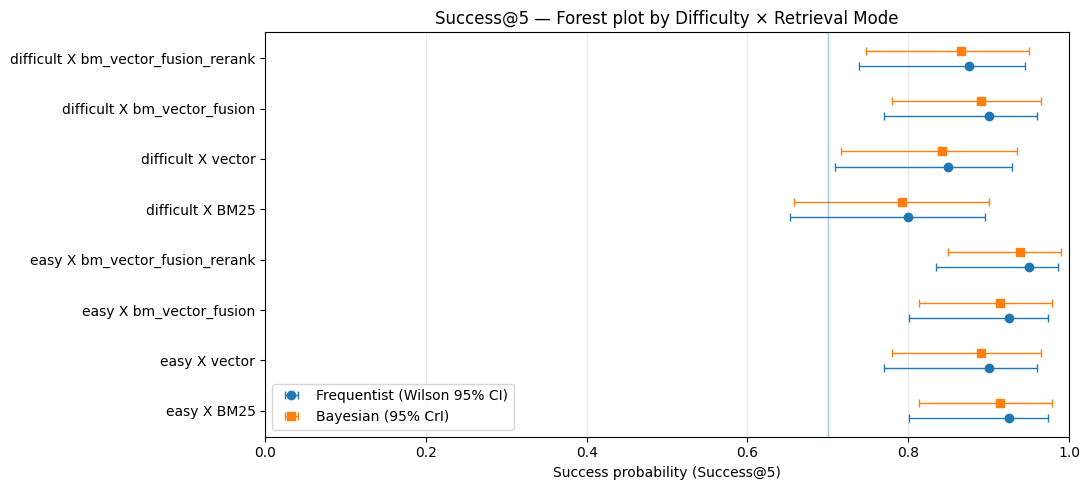

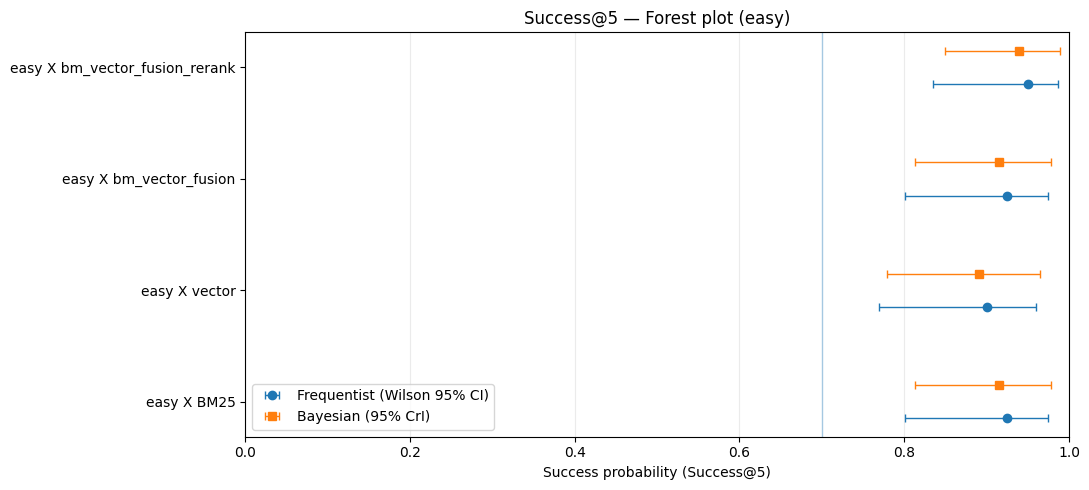

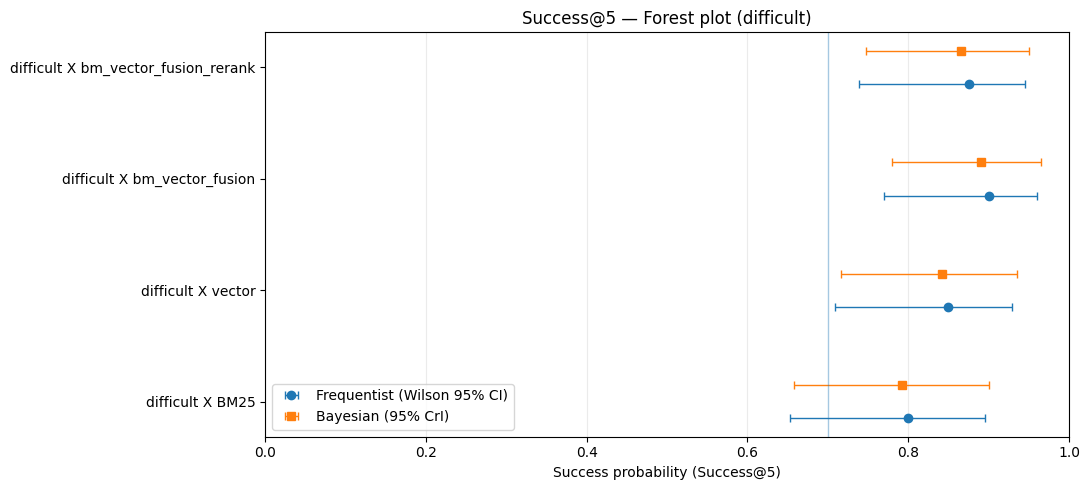

In [12]:
# =========================================================
# Success@5 — Forest plots (FULL PLOTTING CODE)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Canonical ordering (EDIT ONLY IF NEEDED)
# -----------------------------
DIFFICULTY_ORDER = ["easy", "difficult"]

MODE_ORDER = [
    "BM25",
    "bm_vector",
    "bm_vector_fusion",
    "bm_vector_fusion_reranker",
]

# -----------------------------
# Forest plot function
# -----------------------------
def forest_plot_success(
    summary_df: pd.DataFrame,
    MODE_ORDER=None,
    DIFFICULTY_ORDER=None,
    title="Success@5 — Forest plot"
):
    """
    Forest plot for Success@5 showing:
      - Frequentist Wilson CI
      - Bayesian credible interval (Beta-Bernoulli)

    Required columns in summary_df:
      - Difficulty Level
      - Retrieval Mode
      - success_rate
      - wilson_low, wilson_high
      - bayes_mean, bayes_low, bayes_high
    """

    dfp = summary_df.copy()

    # -----------------------------
    # Apply ordering
    # -----------------------------
    if DIFFICULTY_ORDER is None:
        DIFFICULTY_ORDER = list(pd.unique(dfp["Difficulty Level"]))
    if MODE_ORDER is None:
        MODE_ORDER = list(pd.unique(dfp["Retrieval Mode"]))

    dfp["Difficulty Level"] = pd.Categorical(
        dfp["Difficulty Level"],
        categories=DIFFICULTY_ORDER,
        ordered=True
    )
    dfp["Retrieval Mode"] = pd.Categorical(
        dfp["Retrieval Mode"],
        categories=MODE_ORDER,
        ordered=True
    )

    dfp = dfp.sort_values(
        ["Difficulty Level", "Retrieval Mode"]
    ).reset_index(drop=True)

    # Labels: "easy | BM25"
    dfp["label"] = (
        dfp["Difficulty Level"].astype(str)
        + " X "
        + dfp["Retrieval Mode"].astype(str)
    )

    # -----------------------------
    # Y positions (offset for CI types)
    # -----------------------------
    y = np.arange(len(dfp))
    y_w = y - 0.15   # Wilson
    y_b = y + 0.15   # Bayesian

    # -----------------------------
    # X values and errors
    # -----------------------------
    x_w = dfp["success_rate"].to_numpy()
    x_b = dfp["bayes_mean"].to_numpy()

    xerr_w = np.vstack([
        x_w - dfp["wilson_low"].to_numpy(),
        dfp["wilson_high"].to_numpy() - x_w
    ])

    xerr_b = np.vstack([
        x_b - dfp["bayes_low"].to_numpy(),
        dfp["bayes_high"].to_numpy() - x_b
    ])

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(11, max(5, 0.35 * len(dfp) + 2)))

    plt.errorbar(
        x_w, y_w, xerr=xerr_w,
        fmt="o", capsize=3, elinewidth=1,
        label="Frequentist (Wilson 95% CI)"
    )

    plt.errorbar(
        x_b, y_b, xerr=xerr_b,
        fmt="s", capsize=3, elinewidth=1,
        label="Bayesian (95% CrI)"
    )

    plt.yticks(y, dfp["label"])
    plt.xlim(0, 1)
    plt.xlabel("Success probability (Success@5)")
    plt.title(title)

    # Reference line (optional but helpful)
    plt.axvline(0.7, linewidth=1, alpha=0.4)

    plt.grid(axis="x", alpha=0.25)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Combined forest plot
# -----------------------------
forest_plot_success(
    summary_suc,
    MODE_ORDER=MODE_ORDER if set(MODE_ORDER).issubset(set(summary_suc["Retrieval Mode"])) else None,
    DIFFICULTY_ORDER=DIFFICULTY_ORDER if set(DIFFICULTY_ORDER).issubset(set(summary_suc["Difficulty Level"])) else None,
    title="Success@5 — Forest plot by Difficulty × Retrieval Mode"
)

# -----------------------------
# Separate forest plots per difficulty
# -----------------------------
for diff in DIFFICULTY_ORDER:
    df_sub = summary_suc[summary_suc["Difficulty Level"] == diff].copy()
    forest_plot_success(
        df_sub,
        MODE_ORDER=MODE_ORDER if set(MODE_ORDER).issubset(set(df_sub["Retrieval Mode"])) else None,
        DIFFICULTY_ORDER=[diff],
        title=f"Success@5 — Forest plot ({diff})"
    )


Note: While Success@k indicates whether retrieval succeeds, it does not account for the position of the first relevant document. Therefore, we next analyze MRR@k to assess how early relevant documents are retrieved.

## 2 MRR@k (discrete, skewed)

Nature:Discrete values: {0, 1, 1/2, …, 1/5}

Summary: Mean MRR + 95% interval 

(This mean is interpretable as: “Average early-relevance performance (higher means earlier relevant hits).”)

- Frequentist: Bootstrap CI for the mean MRR@k
- Bayesian: Dirichlet–Multinomial model (posterior + credible interval for the mean MRR@k))

Distribution plot: 
- Violin
- empirical cumulative distribution function (ECDF)


Key question: How early does retrieval succeed when it does succeed?

#### Violin:

    Dots show discrete MRR values (0, 1, 1/2, …)

    Wider violin → higher variability across queries


    Median near 0 → late or failed retrieval is common

    More dots near 1 → more rank-1 hits

    Higher median → earlier relevance on average

    Crossing medians → interaction effect


    Mean > median → few early hits pull average upward

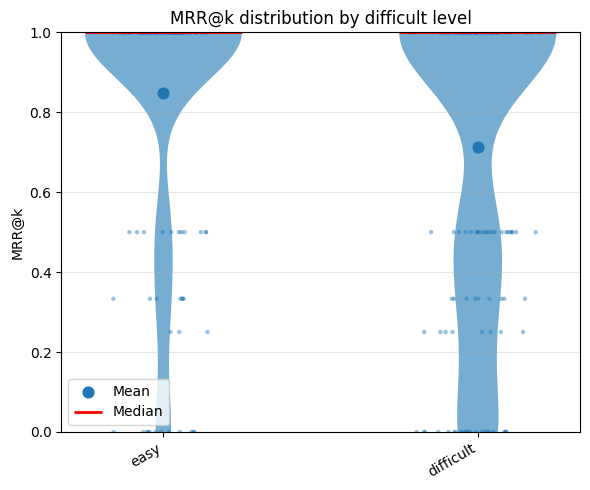

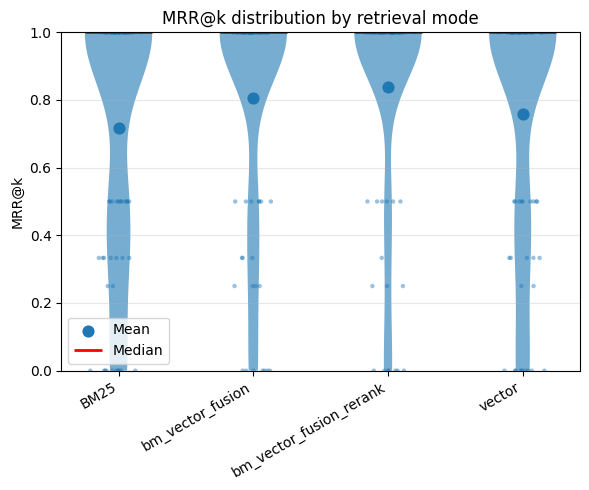

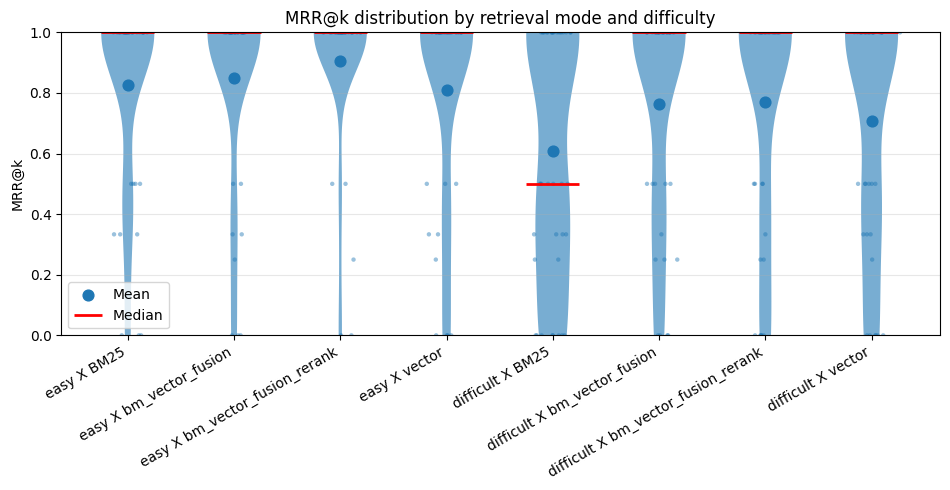

In [13]:
# Helper function: violin + dots + mean + median

import numpy as np
import matplotlib.pyplot as plt

def violin_with_points(
    data_list,
    labels,
    title,
    ylabel="MRR@k",
    ylim=(0, 1),
    jitter=0.08
):
    """
    data_list : list of 1D arrays (one per group)
    labels    : x-axis labels
    """

    x = np.arange(1, len(data_list) + 1)

    plt.figure(figsize=(max(6, 1.2 * len(data_list)), 5))

    # Violin
    vp = plt.violinplot(
        data_list,
        positions=x,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )

    for body in vp["bodies"]:
        body.set_alpha(0.6)

    # Jittered dots (smaller, unique color)
    for i, y in enumerate(data_list, start=1):
        x_jitter = np.random.normal(i, jitter, size=len(y))
        plt.scatter(
            x_jitter,
            y,
            s=10,                 # smaller dots
            color="tab:blue",     # unique, readable color
            alpha=0.45,
            edgecolors="none"
        )


    # Mean and median
    means = [np.mean(y) for y in data_list]
    medians = [np.median(y) for y in data_list]

    plt.scatter(x, means, marker="o", s=60, zorder=3, label="Mean")
    plt.hlines(medians, x - 0.25, x + 0.25, linewidth=2, label="Median",color="red")

    # Formatting
    plt.xticks(x, labels, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
# Level 1 — By difficult level 
difficult = metrics_df["Difficulty Level"].unique()

data_by_difficult = [
    metrics_df.loc[metrics_df["Difficulty Level"] == m, "mrr@k"].dropna().values
    for m in difficult
]

violin_with_points(
    data_list=data_by_difficult,
    labels=difficult,
    title="MRR@k distribution by difficult level"
)

# Level 2 — By retrieval mode
modes = metrics_df["Retrieval Mode"].unique()

data_by_mode = [
    metrics_df.loc[metrics_df["Retrieval Mode"] == m, "mrr@k"].dropna().values
    for m in modes
]

violin_with_points(
    data_list=data_by_mode,
    labels=modes,
    title="MRR@k distribution by retrieval mode"
)

# Level 3 — Retrieval mode × difficulty
difficulty_levels = metrics_df["Difficulty Level"].unique()

data = []
labels = []

for diff in difficulty_levels:
    for mode in modes:
        subset = metrics_df[
            (metrics_df["Difficulty Level"] == diff) &
            (metrics_df["Retrieval Mode"] == mode)
        ]["mrr@k"].dropna().values
        data.append(subset)
        labels.append(f"{diff} X {mode}")

violin_with_points(
    data_list=data,
    labels=labels,
    title="MRR@k distribution by retrieval mode and difficulty"
)

#### empirical cumulative distribution functions (ECDFs)

Given the discrete and highly skewed nature of MRR@k, ECDFs were used to visualize and compare the full distribution of early-relevance performance across retrieval modes. ECDFs explicitly reveal zero inflation and dominance relationships that are not apparent from mean-based summaries alone.

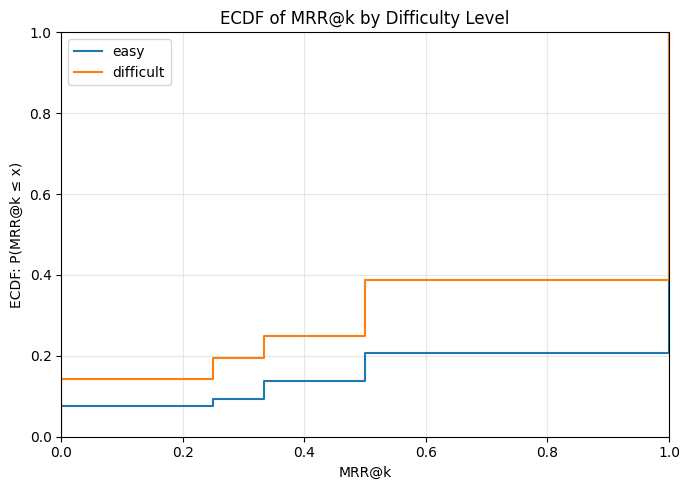

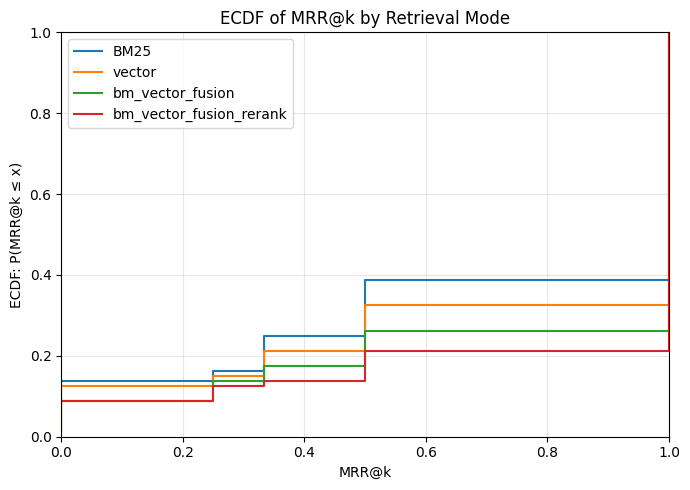

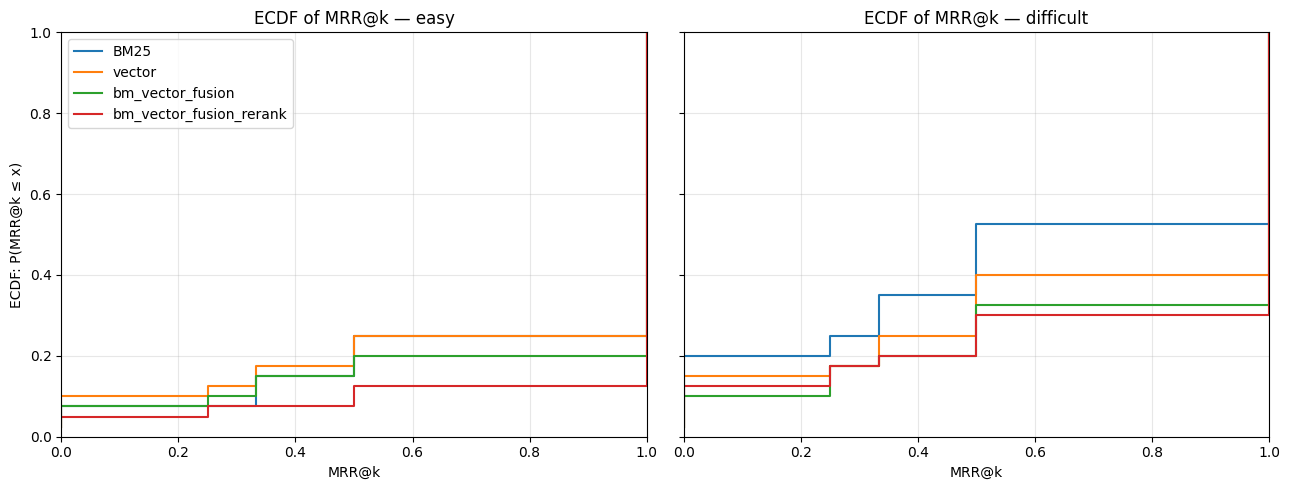

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Canonical ordering (use everywhere)
# -----------------------------
DIFFICULTY_ORDER = ["easy", "difficult"]

MODE_ORDER = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

# -----------------------------
# ECDF helper
# -----------------------------
def ecdf(y):
    """Return x,y for an ECDF."""
    y = np.asarray(y)
    y = y[~np.isnan(y)]
    y = np.sort(y)
    n = len(y)
    if n == 0:
        return np.array([]), np.array([])
    return y, np.arange(1, n + 1) / n

def plot_ecdf(ax, y, label=None):
    """Plot ECDF as a step function on the given axes."""
    x, F = ecdf(y)
    if len(x) == 0:
        return
    ax.step(x, F, where="post", label=label)

# Ensure consistent category ordering (optional but recommended)
metrics_df = metrics_df.copy()
metrics_df["Difficulty Level"] = pd.Categorical(
    metrics_df["Difficulty Level"], categories=DIFFICULTY_ORDER, ordered=True
)
metrics_df["Retrieval Mode"] = pd.Categorical(
    metrics_df["Retrieval Mode"], categories=MODE_ORDER, ordered=True
)

# ============================================================
# (A) By difficulty level (collapse over retrieval mode)
# ============================================================
plt.figure(figsize=(7, 5))
ax = plt.gca()

for diff in DIFFICULTY_ORDER:
    y = metrics_df.loc[metrics_df["Difficulty Level"] == diff, "mrr@k"].dropna().values
    plot_ecdf(ax, y, label=str(diff))

ax.set_title("ECDF of MRR@k by Difficulty Level")
ax.set_xlabel("MRR@k")
ax.set_ylabel("ECDF: P(MRR@k ≤ x)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

# ============================================================
# (B) By retrieval mode (collapse over difficulty)
# ============================================================
plt.figure(figsize=(7, 5))
ax = plt.gca()

for mode in MODE_ORDER:
    y = metrics_df.loc[metrics_df["Retrieval Mode"] == mode, "mrr@k"].dropna().values
    plot_ecdf(ax, y, label=str(mode))

ax.set_title("ECDF of MRR@k by Retrieval Mode")
ax.set_xlabel("MRR@k")
ax.set_ylabel("ECDF: P(MRR@k ≤ x)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


# ============================================================
# (C) Interaction: retrieval mode × difficulty (facet by difficulty)
# ============================================================
fig, axes = plt.subplots(1, len(DIFFICULTY_ORDER), figsize=(13, 5), sharex=True, sharey=True)

for ax, diff in zip(axes, DIFFICULTY_ORDER):
    df_sub = metrics_df[metrics_df["Difficulty Level"] == diff]
    for mode in MODE_ORDER:
        y = df_sub.loc[df_sub["Retrieval Mode"] == mode, "mrr@k"].dropna().values
        plot_ecdf(ax, y, label=str(mode))

    ax.set_title(f"ECDF of MRR@k — {diff}")
    ax.set_xlabel("MRR@k")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("ECDF: P(MRR@k ≤ x)")
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

axes[0].legend(loc="upper left")
plt.tight_layout()
plt.show()


Curves that lie lower / more to the right indicate better early relevance (higher MRR@k), while a large jump at MRR@k = 0 indicates many queries with no relevant document in the top-k(not in our RAG).

MRR@k considers only the first relevant document,it does not account for the presence or ordering of additional relevant documents, nor does it incorporate graded relevance. To assess overall ranking quality within the top-k results, we therefore analyze nDCG@k, which rewards placing highly relevant documents early and penalizes suboptimal ordering.

#### Bootstrap CI (frequentist)

Goal: uncertainty for mean MRR@k without assuming normality
Why it fits MRR@k: MRR is discrete + spiky at 0 and 1 → non-normal.

Method (per group):

- Sample queries with replacement within group

- Recompute mean MRR

- Repeat B times (e.g., 10,000)

- CI = percentile interval (2.5%, 97.5%) or BCa (optional)

Parameters to state
- B = number of bootstrap resamples (recommend: 10,000)
- CI level: 95%
- Sampling unit: query (not rows of retrieved docs)


#### Dirichlet–Multinomial (Bayesian)

“Intervals were computed at the query level. Frequentist uncertainty for mean MRR@k was estimated via nonparametric bootstrap resampling, while Bayesian uncertainty was estimated using a Dirichlet–Multinomial model over the discrete set of possible MRR@k values.”

Goal: posterior uncertainty for the mean MRR using the correct discrete support.

Key idea: treat MRR outcomes as 6 categories:{0,1/5,1/4,1/3,1/2,1},Let category probabilities be 𝜋=(....)

Model (per group): 
- Likelihood: category counts c~Multinomial(n,π)
- Prior: π∼Dirichlet(α) (often symmetric).“Uniform”: 𝛼=1 for all categories
- Posterior: π∣c∼Dirichlet(α+c)
- get a credible interval for μ by sampling π from the posterior and computing μ each draw.



In [15]:
#1. Helpers: Bootstrap CI + Dirichlet–Multinomial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import dirichlet

# -----------------------------
# Bootstrap CI for mean
# -----------------------------
def bootstrap_ci_mean(x, B=10_000, alpha=0.05, random_state=0):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    n = len(x)

    boot_means = [
        np.mean(rng.choice(x, size=n, replace=True))
        for _ in range(B)
    ]
    low = np.percentile(boot_means, 100 * alpha / 2)
    high = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return np.mean(x), low, high


# -----------------------------
# Dirichlet–Multinomial posterior for mean MRR
# -----------------------------
MRR_VALUES = np.array([0, 1/5, 1/4, 1/3, 1/2, 1])

def dirichlet_mrr_posterior(x, alpha0=1.0, draws=50_000):
    """
    x: array of observed MRR values
    alpha0: symmetric Dirichlet prior
    """
    counts = np.array([(x == v).sum() for v in MRR_VALUES])
    alpha_post = counts + alpha0

    pi_samples = dirichlet.rvs(alpha_post, size=draws)
    mean_samples = pi_samples @ MRR_VALUES

    mean_est = mean_samples.mean()
    low, high = np.percentile(mean_samples, [2.5, 97.5])
    return mean_est, low, high

# 2. Core summarization function (used everywhere)
def summarize_mrr(group):
    x = group["mrr@k"].values

    # Bootstrap CI
    mean_mrr, boot_low, boot_high = bootstrap_ci_mean(x)

    # Bayesian Dirichlet–Multinomial
    bayes_mean, bayes_low, bayes_high = dirichlet_mrr_posterior(x)

    # Rank-1 rate (ceiling diagnostic)
    rank1_rate = np.mean(x == 1)

    return pd.Series({
        "n": len(x),
        "mean_mrr": mean_mrr,
        "boot_low": boot_low,
        "boot_high": boot_high,
        "bayes_mean": bayes_mean,
        "bayes_low": bayes_low,
        "bayes_high": bayes_high,
        "rank1_rate": rank1_rate
    })



In [16]:
# Level A — By retrieval mode (collapse over difficulty):
# “Which retrieval mode surfaces relevant documents earlier on average, across all queries?”

table_A = (
    metrics_df
    .groupby("Retrieval Mode")
    .apply(summarize_mrr)
    .reindex(MODE_ORDER)
)

display(table_A)


# Level B — By difficulty level (collapse over retrieval mode):
# “How much does difficulty affect early relevance overall?”

table_B = (
    metrics_df
    .groupby("Difficulty Level")
    .apply(summarize_mrr)
    .reindex(DIFFICULTY_ORDER)
)

display(table_B)


#Level C — Interaction: retrieval mode × difficulty (facet by difficulty):
# “Do retrieval modes degrade differently on difficult questions?”

table_C = (
    metrics_df
    .groupby(["Difficulty Level", "Retrieval Mode"])
    .apply(summarize_mrr)
    .reindex(
        pd.MultiIndex.from_product(
            [DIFFICULTY_ORDER, MODE_ORDER],
            names=["Difficulty Level", "Retrieval Mode"]
        )
    )
)

display(table_C)



/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3886799860.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3886799860.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n,mean_mrr,boot_low,boot_high,bayes_mean,bayes_low,bayes_high,rank1_rate
Retrieval Mode,,,,,,,,
BM25,80.0,0.716667,0.632292,0.800000,0.693394,0.609075,0.771654,0.6125
vector,80.0,0.758333,0.673958,0.837526,0.732186,0.649244,0.807669,0.6750
bm_vector_fusion,80.0,0.806250,0.729167,0.879167,0.776146,0.696994,0.846311,0.7375
bm_vector_fusion_rerank,80.0,0.838542,0.764583,0.906250,0.806628,0.729215,0.874310,0.7875


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3886799860.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3886799860.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n,mean_mrr,boot_low,boot_high,bayes_mean,bayes_low,bayes_high,rank1_rate
Difficulty Level,,,,,,,,
easy,160.0,0.847396,0.797396,0.893229,0.830433,0.778226,0.876851,0.79375
difficult,160.0,0.712500,0.652083,0.771354,0.700458,0.639773,0.757701,0.61250


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3886799860.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3886799860.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



n  mean_mrr  boot_low  boot_high  \
Difficulty Level Retrieval Mode                                                 
easy             BM25                     40.0  0.825000  0.720833   0.916667   
                 vector                   40.0  0.810417  0.700000   0.912500   
                 bm_vector_fusion         40.0  0.847917  0.745833   0.939583   
                 bm_vector_fusion_rerank  40.0  0.906250  0.818750   0.975000   
difficult        BM25                     40.0  0.608333  0.481250   0.731250   
                 vector                   40.0  0.706250  0.581250   0.822917   
                 bm_vector_fusion         40.0  0.764583  0.647917   0.870833   
                 bm_vector_fusion_rerank  40.0  0.770833  0.652083   0.879167   

                                          bayes_mean  bayes_low  bayes_high  \
Difficulty Level Retrieval Mode                                               
easy             BM25                       0.767043   0.660099    0.859359   
                 vector                     0.754715   0.640809    0.852207   
                 bm_vector_fusion           0.786726   0.677849    0.877809   
                 bm_vector_fusion_rerank    0.837910   0.737421    0.917866   
difficult        BM25                       0.578747   0.462260    0.691839   
                 vector                     0.663502   0.546676    0.770502   
                 bm_vector_fusion           0.714488   0.601743    0.816359   
                 bm_vector_fusion_rerank    0.719526   0.603036    0.822286   

                                          rank1_rate  
Difficulty Level Retrieval Mode                       
easy             BM25                          0.750  
                 vector                        0.750  
                 bm_vector_fusion              0.800  
                 bm_vector_fusion_rerank       0.875  
difficult        BM25                          0.475  
                 vector                        0.600  
                 bm_vector_fusion              0.675  
                 bm_vector_fusion_rerank       0.700

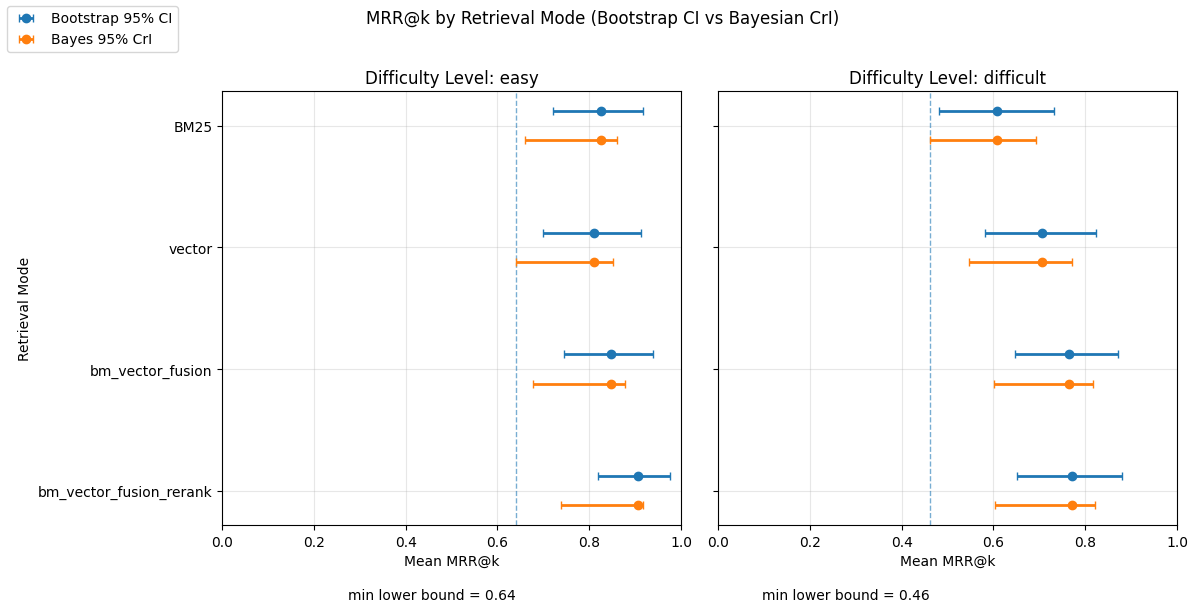

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mrr_facet_intervals(table_C, DIFFICULTY_ORDER, MODE_ORDER):
    """
    table_C must contain:
      - Difficulty Level
      - Retrieval Mode
      - mean_mrr
      - boot_low, boot_high
      - bayes_low, bayes_high
    """

    fig, axes = plt.subplots(
        1, len(DIFFICULTY_ORDER),
        figsize=(12, 6),
        sharex=True,
        sharey=True
    )

    if len(DIFFICULTY_ORDER) == 1:
        axes = [axes]

    for ax, diff in zip(axes, DIFFICULTY_ORDER):
        sub = table_C.loc[diff].copy()
        sub = sub.reindex(MODE_ORDER)

        # y positions (top-down)
        y = np.arange(len(MODE_ORDER))[::-1]

        # Conservative lower bound (min of bootstrap & Bayesian)
        sub["low_conservative"] = np.minimum(
            sub["boot_low"], sub["bayes_low"]
        )
        vline = np.nanmin(sub["low_conservative"].values)

        ax.axvline(
            vline,
            linestyle="--",
            linewidth=1,
            alpha=0.6
        )

        offset = 0.12

        # Bootstrap CI
        ax.errorbar(
            sub["mean_mrr"],
            y + offset,
            xerr=[
                sub["mean_mrr"] - sub["boot_low"],
                sub["boot_high"] - sub["mean_mrr"]
            ],
            fmt="o",
            capsize=3,
            linewidth=2,
            label="Bootstrap 95% CI"
        )

        # Bayesian CrI
        ax.errorbar(
            sub["mean_mrr"],
            y - offset,
            xerr=[
                sub["mean_mrr"] - sub["bayes_low"],
                sub["bayes_high"] - sub["mean_mrr"]
            ],
            fmt="o",
            capsize=3,
            linewidth=2,
            label="Bayes 95% CrI"
        )

        ax.set_yticks(y)
        ax.set_yticklabels(MODE_ORDER)
        ax.set_title(f"Difficulty Level: {diff}")
        ax.set_xlabel("Mean MRR@k")
        ax.set_xlim(0, 1)
        ax.grid(alpha=0.3)

        ax.text(
            vline,
            y.min() - 0.8,
            f"min lower bound = {vline:.2f}",
            ha="right",
            va="top"
        )

    axes[0].set_ylabel("Retrieval Mode")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper left",
        frameon=True
    )

    fig.suptitle(
        "MRR@k by Retrieval Mode (Bootstrap CI vs Bayesian CrI)",
        y=1.02
    )

    plt.tight_layout()
    plt.show()
    
plot_mrr_facet_intervals(table_C, DIFFICULTY_ORDER, MODE_ORDER)


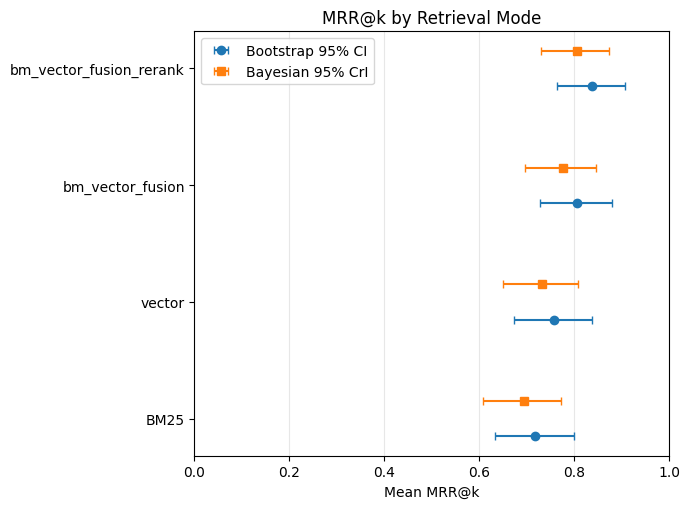

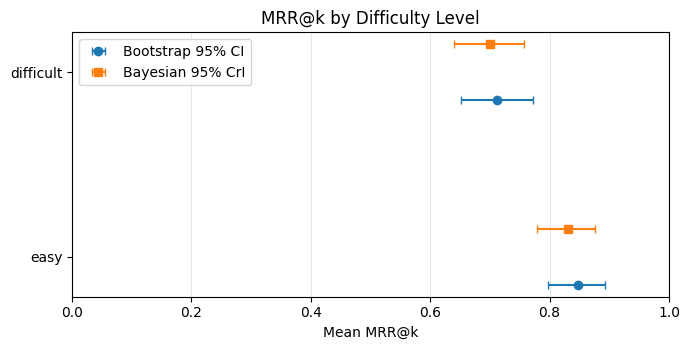

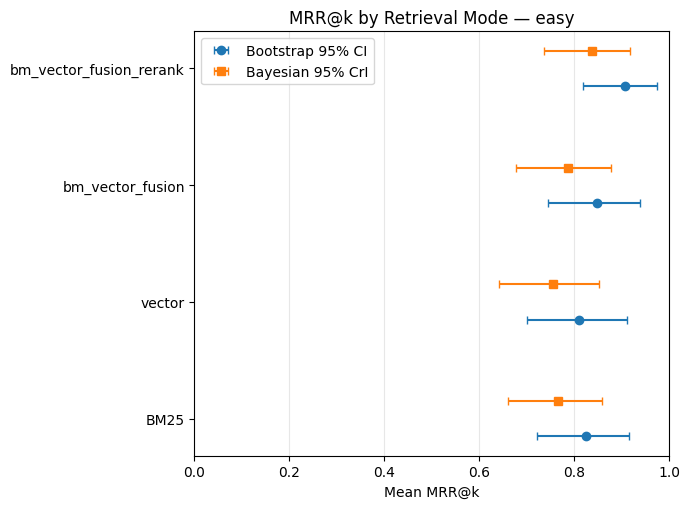

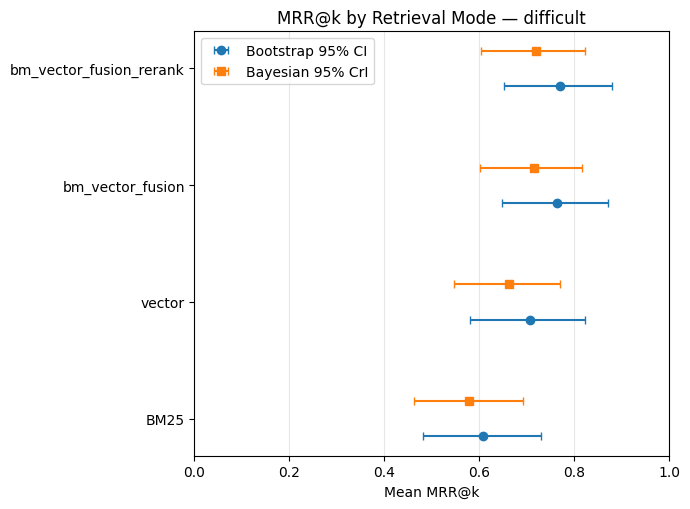

In [18]:
def forest_plot_separated(table, title, delta=0.15):
    """
    Forest plot with vertically separated Bootstrap CI and Bayesian CrI.
    """
    y = np.arange(len(table))

    plt.figure(figsize=(7, 0.8 * len(table) + 2))

    # --- Bootstrap CI (lower offset) ---
    plt.errorbar(
        table["mean_mrr"],
        y - delta,
        xerr=[
            table["mean_mrr"] - table["boot_low"],
            table["boot_high"] - table["mean_mrr"]
        ],
        fmt="o",
        capsize=3,
        label="Bootstrap 95% CI"
    )

    # --- Bayesian CrI (upper offset) ---
    plt.errorbar(
        table["bayes_mean"],
        y + delta,
        xerr=[
            table["bayes_mean"] - table["bayes_low"],
            table["bayes_high"] - table["bayes_mean"]
        ],
        fmt="s",
        capsize=3,
        label="Bayesian 95% CrI"
    )

    # Y-axis labels
    plt.yticks(y, table.index)

    plt.xlabel("Mean MRR@k")
    plt.title(title)
    plt.xlim(0, 1)
    plt.grid(axis="x", alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

forest_plot_separated(table_A, "MRR@k by Retrieval Mode")
forest_plot_separated(table_B, "MRR@k by Difficulty Level")
forest_plot_separated(table_C.loc["easy"], "MRR@k by Retrieval Mode — easy")
forest_plot_separated(table_C.loc["difficult"], "MRR@k by Retrieval Mode — difficult")


## 3 nDCG@k (continuous, bounded)

Nature: Continuous in [0,1]

- 0 → no gain in top-k (e.g., no relevant docs retrieved)
- 1 → ideal ranking (under your judged set)
- in-between(0,1) → partially correct ordering and/or lower relevance

Spread : violin plot -Show median and IQR

Key question: How well are relevant documents ranked overall?




Summary: Mean nDCG ,95% interval
- Frequentist: Bootstrap CI for the mean nDCG@k
    - Goal: uncertainty for the mean nDCG without parametric assumptions.

    - Why it fits: nDCG is bounded [0,1] , violin plots show spikes at 0 and 1,normality assumptions are not appropriate,bootstrap works well with 
n=40 per cell

    - Method (per group):Resample queries within group with replacement,Recompute mean nDCG,Repeat B times (e.g., 10,000),CI = percentile (2.5%, 97.5%) or BCa (optional).

    - Parameters to report: bootstrap draws B,CI level 95%, sampling unit = query

- Bayesian: Zero–One Inflated Beta (ZOIB) to handle spikes at 0 and 1
    - Goal: model nDCG distribution realistically: point mass at 0, point mass at 1, Beta in (0,1).
    - Why it fits: exactly matches observed structure (0/1 inflation + continuous middle),
    - gives a posterior over:
        - probability of zero outcomes p0
        - probability of perfect outcomes p1
        - shape of the continuous part
    - report from ZOIB: Posterior mean of group mean, 95% credible interval
    - Parameters to report:
        - priors for p0,p1
        - prior for Beta parameters (or for mean/precision parameterization)
        - number of posterior draws / iterations
        - credible interval type (equal-tailed 95%)

	​


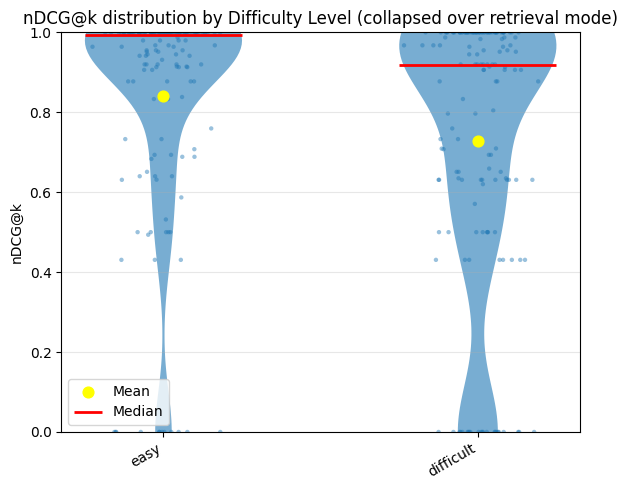

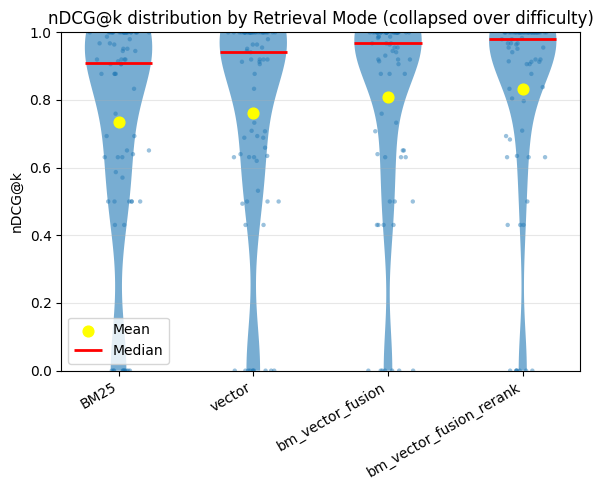

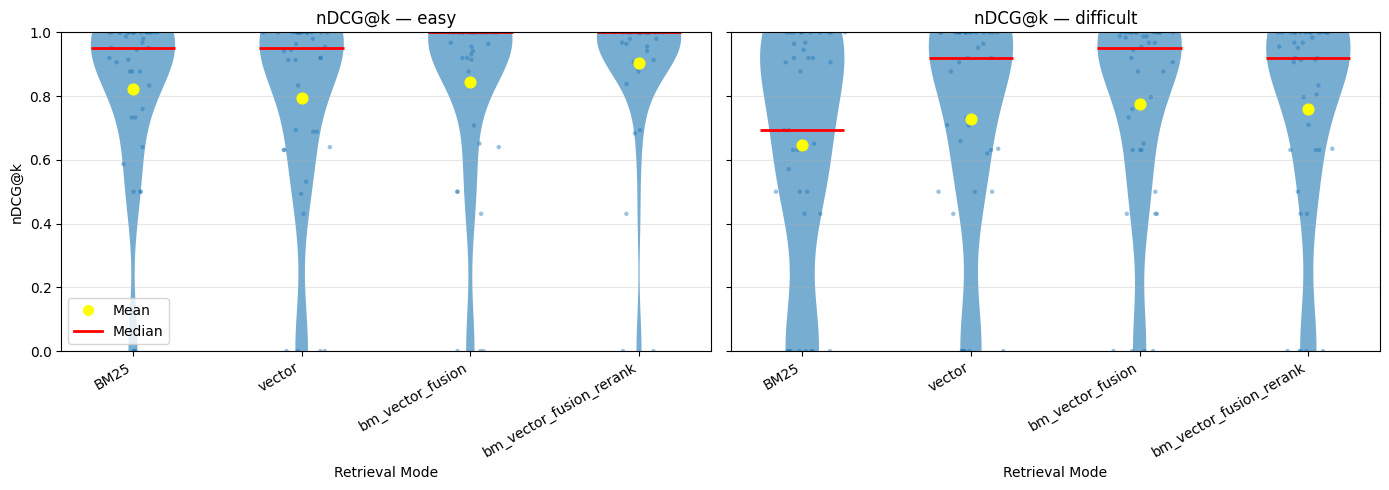

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Canonical ordering (use everywhere)
# -----------------------------
DIFFICULTY_ORDER = ["easy", "difficult"]

MODE_ORDER = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

# Ensure consistent category ordering
dfp = metrics_df.copy()
dfp["Difficulty Level"] = pd.Categorical(dfp["Difficulty Level"], categories=DIFFICULTY_ORDER, ordered=True)
dfp["Retrieval Mode"] = pd.Categorical(dfp["Retrieval Mode"], categories=MODE_ORDER, ordered=True)

# -----------------------------
# Violin helper: dots + mean + median
# -----------------------------
def violin_with_points(
    data_list,
    labels,
    title,
    ylabel="nDCG@k",
    ylim=(0, 1),
    jitter=0.08,
    dot_size=10,
    dot_color="tab:blue",
    median_color="red",
    mean_color="yellow",
    rotate=30
):
    x = np.arange(1, len(data_list) + 1)

    plt.figure(figsize=(max(6, 1.2 * len(data_list)), 5))

    vp = plt.violinplot(
        data_list,
        positions=x,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for body in vp["bodies"]:
        body.set_alpha(0.6)

    # Jittered dots
    for i, y in enumerate(data_list, start=1):
        y = np.asarray(y)
        y = y[~np.isnan(y)]
        x_j = np.random.normal(i, jitter, size=len(y))
        plt.scatter(x_j, y, s=dot_size, color=dot_color, alpha=0.45, edgecolors="none")

    # Mean + Median
    means = [np.nanmean(y) for y in data_list]
    medians = [np.nanmedian(y) for y in data_list]
    plt.scatter(x, means, marker="o", s=60, color=mean_color, zorder=3, label="Mean")
    plt.hlines(medians, x - 0.25, x + 0.25, linewidth=2, color=median_color, label="Median")

    plt.xticks(x, labels, rotation=rotate, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

# ============================================================
# (A) By difficulty level (collapse over retrieval mode)
# ============================================================
data_A = [
    dfp.loc[dfp["Difficulty Level"] == diff, "ndcg@k"].dropna().values
    for diff in DIFFICULTY_ORDER
]
labels_A = DIFFICULTY_ORDER

violin_with_points(
    data_list=data_A,
    labels=labels_A,
    title="nDCG@k distribution by Difficulty Level (collapsed over retrieval mode)",
    ylabel="nDCG@k",
)

# ============================================================
# (B) By retrieval mode (collapse over difficulty)
# ============================================================
data_B = [
    dfp.loc[dfp["Retrieval Mode"] == mode, "ndcg@k"].dropna().values
    for mode in MODE_ORDER
]
labels_B = MODE_ORDER

violin_with_points(
    data_list=data_B,
    labels=labels_B,
    title="nDCG@k distribution by Retrieval Mode (collapsed over difficulty)",
    ylabel="nDCG@k",
)

# ============================================================
# (C) Interaction: retrieval mode × difficulty (facet by difficulty)
# ============================================================
fig, axes = plt.subplots(1, len(DIFFICULTY_ORDER), figsize=(14, 5), sharey=True)

for ax, diff in zip(axes, DIFFICULTY_ORDER):
    sub = dfp[dfp["Difficulty Level"] == diff]

    data_C = [
        sub.loc[sub["Retrieval Mode"] == mode, "ndcg@k"].dropna().values
        for mode in MODE_ORDER
    ]

    x = np.arange(1, len(MODE_ORDER) + 1)

    vp = ax.violinplot(
        data_C,
        positions=x,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for body in vp["bodies"]:
        body.set_alpha(0.6)

    # dots
    for i, y in enumerate(data_C, start=1):
        y = np.asarray(y)
        y = y[~np.isnan(y)]
        x_j = np.random.normal(i, 0.08, size=len(y))
        ax.scatter(x_j, y, s=10, color="tab:blue", alpha=0.45, edgecolors="none")

    # mean + median
    means = [np.nanmean(y) for y in data_C]
    medians = [np.nanmedian(y) for y in data_C]
    ax.scatter(x, means, marker="o", s=60, color="yellow", zorder=3)
    ax.hlines(medians, x - 0.25, x + 0.25, linewidth=2, color="red")

    ax.set_title(f"nDCG@k — {diff}")
    ax.set_xticks(x)
    ax.set_xticklabels(MODE_ORDER, rotation=30, ha="right")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)
    ax.set_xlabel("Retrieval Mode")

axes[0].set_ylabel("nDCG@k")
# One shared legend (manual)
handles = [
    plt.Line2D([0], [0], marker="o", color="yellow", linestyle="None", markersize=7, label="Mean"),
    plt.Line2D([0], [0], color="red", linewidth=2, label="Median"),
]
axes[0].legend(handles=handles, loc="lower left")

plt.tight_layout()
plt.show()


#### Uncertainty Estimation for nDCG@k

##### Bootstrap Confidence Intervals (Frequentist)

- **Resampling method:** Nonparametric bootstrap
- **Number of resamples:** `BOOT_B = 10,000`
- **Confidence level:** `1 − BOOT_ALPHA = 95%`
- **Target statistic:** Mean nDCG@k
- **Resampling unit:** Query-level observations within each group
- **Interval type:** Percentile bootstrap confidence interval


#### Zero–One Inflated Beta (ZOIB) Bayesian Credible Intervals

- **Mixture structure:**
  - Point mass at 0
  - Point mass at 1
  - Beta distribution on the open interval (0, 1)

- **Mixture weights prior:**
  
  (w_0, w_1, w_m) ~ Dirichlet(1, 1, 1)

- **Middle component (Beta) parameters:**
  - alpha, beta fitted by maximum likelihood estimation (MLE)
  - Fitted using only observations in the open interval (0, 1)
  - Empirical Bayes approach

- **Posterior sampling:**
  - Number of posterior draws: `POST_DRAWS = 50,000`

- **Credible interval:**
  - Mass: `CRED_MASS = 95%`
  - Type: Equal-tailed credible interval

- **Group mean computation:**

  E[Y] = w_1 + w_m * alpha/(alpha + beta)
  


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2299283767.py:249: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2299283767.py:250: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n,mean_ndcg,boot_low,boot_high,bayes_mean,bayes_low,bayes_high,zero_rate,one_rate,mid_rate,beta_alpha_hat,beta_beta_hat
Difficulty Level,,,,,,,,,,,,
easy,160.0,0.841239,0.796633,0.882935,0.836774,0.793457,0.873249,0.07500,0.5000,0.42500,3.843948,0.943536
difficult,160.0,0.727596,0.671682,0.780806,0.724987,0.672762,0.771194,0.14375,0.3375,0.51875,3.194446,1.053527


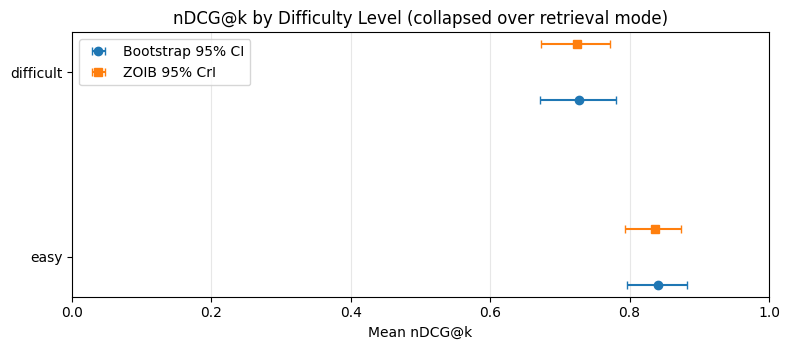

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2299283767.py:262: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2299283767.py:263: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n,mean_ndcg,boot_low,boot_high,bayes_mean,bayes_low,bayes_high,zero_rate,one_rate,mid_rate,beta_alpha_hat,beta_beta_hat
Retrieval Mode,,,,,,,,,,,,
BM25,80.0,0.734712,0.658179,0.804585,0.729532,0.655872,0.792152,0.1375,0.3250,0.5375,3.364327,1.049322
vector,80.0,0.760932,0.686480,0.829697,0.754506,0.681001,0.816415,0.1250,0.4250,0.4500,3.632177,1.233328
bm_vector_fusion,80.0,0.810043,0.742752,0.874283,0.802262,0.735955,0.855790,0.0875,0.4375,0.4750,2.952654,0.812039
bm_vector_fusion_rerank,80.0,0.831984,0.765190,0.893751,0.823721,0.756215,0.877174,0.0875,0.4875,0.4250,4.005921,0.936302


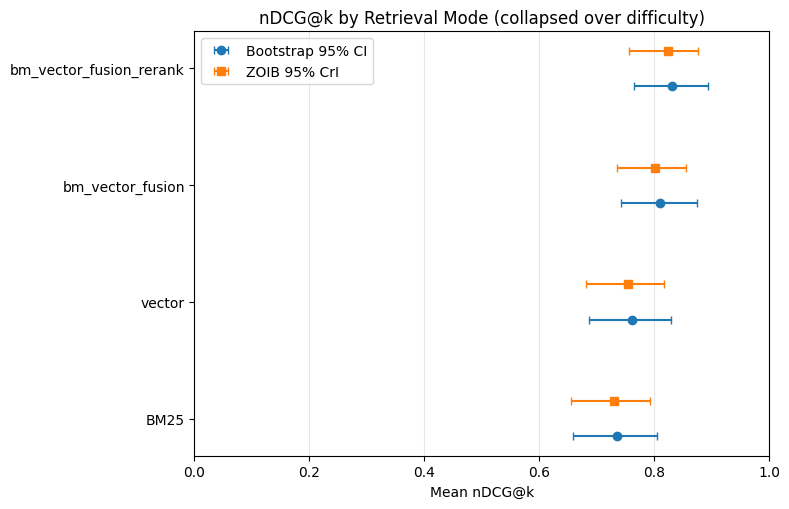

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2299283767.py:275: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2299283767.py:276: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



n  mean_ndcg  boot_low  \
Difficulty Level Retrieval Mode                                       
easy             BM25                     40.0   0.823470  0.730719   
                 vector                   40.0   0.792792  0.690650   
                 bm_vector_fusion         40.0   0.845476  0.752557   
                 bm_vector_fusion_rerank  40.0   0.903220  0.823621   
difficult        BM25                     40.0   0.645954  0.530354   
                 vector                   40.0   0.729073  0.614017   
                 bm_vector_fusion         40.0   0.774611  0.671575   
                 bm_vector_fusion_rerank  40.0   0.760748  0.651930   

                                          boot_high  bayes_mean  bayes_low  \
Difficulty Level Retrieval Mode                                              
easy             BM25                      0.901719    0.808130   0.714161   
                 vector                    0.882323    0.778768   0.678004   
                 bm_vector_fusion          0.925321    0.827836   0.731275   
                 bm_vector_fusion_rerank   0.967649    0.881565   0.793796   
difficult        BM25                      0.756669    0.646248   0.536099   
                 vector                    0.832172    0.722489   0.611504   
                 bm_vector_fusion          0.867274    0.761817   0.664227   
                 bm_vector_fusion_rerank   0.856387    0.749034   0.644938   

                                          bayes_high  zero_rate  one_rate  \
Difficulty Level Retrieval Mode                                             
easy             BM25                       0.875760      0.075     0.400   
                 vector                     0.855835      0.100     0.425   
                 bm_vector_fusion           0.897973      0.075     0.550   
                 bm_vector_fusion_rerank    0.938680      0.050     0.625   
difficult        BM25                       0.741202      0.200     0.250   
                 vector                     0.813330      0.150     0.425   
                 bm_vector_fusion           0.836636      0.100     0.325   
                 bm_vector_fusion_rerank    0.831644      0.125     0.350   

                                          mid_rate  beta_alpha_hat  \
Difficulty Level Retrieval Mode                                      
easy             BM25                        0.525        4.171403   
                 vector                      0.475        3.536292   
                 bm_vector_fusion            0.375        3.565835   
                 bm_vector_fusion_rerank     0.325        4.897584   
difficult        BM25                        0.550        3.485951   
                 vector                      0.425        4.045963   
                 bm_vector_fusion            0.575        2.800040   
                 bm_vector_fusion_rerank     0.525        3.623016   

                                          beta_beta_hat  
Difficulty Level Retrieval Mode                          
easy             BM25                          1.000120  
                 vector                        1.030803  
                 bm_vector_fusion              0.959710  
                 bm_vector_fusion_rerank       0.864655  
difficult        BM25                          1.291628  
                 vector                        1.532425  
                 bm_vector_fusion              0.780886  
                 bm_vector_fusion_rerank       1.007766

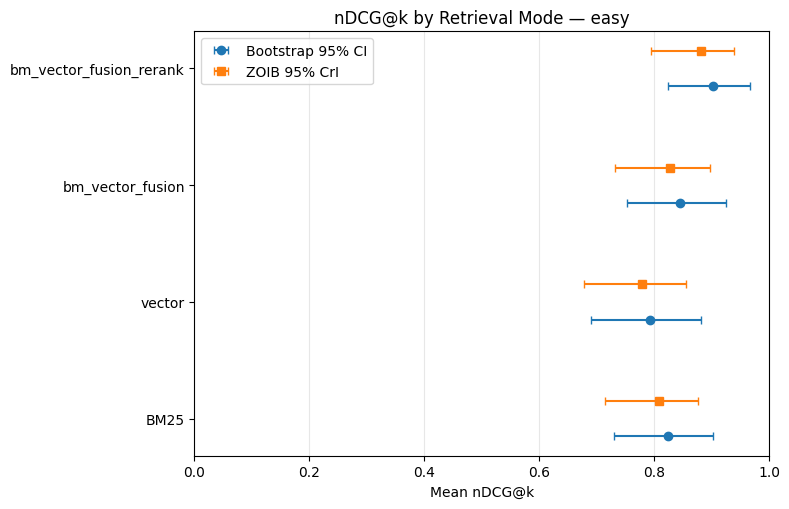

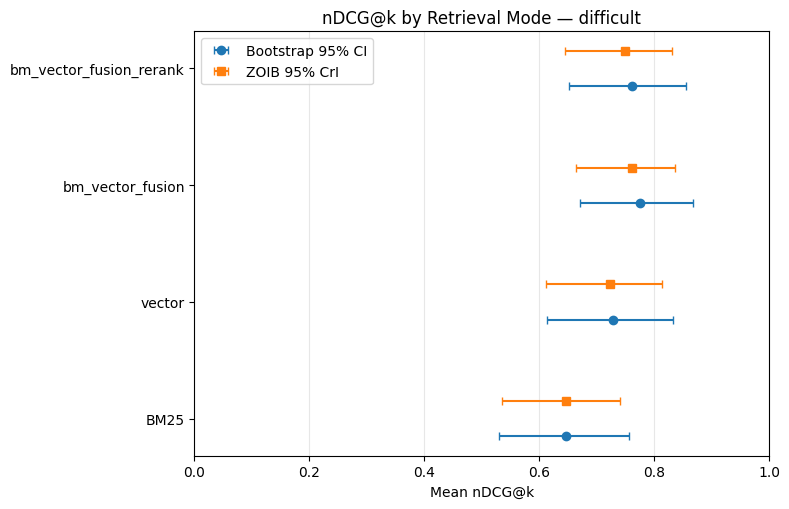

In [20]:
# nDCG@k: Bootstrap CI (frequentist) + ZOIB-style Bayesian CrI (Dirichlet mixture + Beta middle)
# -------------------------------------------------------------------------------------------
# What this code does (per group):
#   1) Frequentist: nonparametric bootstrap CI for mean nDCG@k
#   2) Bayesian (ZOIB): models nDCG as a 3-component mixture:
#        - point mass at 0
#        - point mass at 1
#        - Beta distribution on (0,1)
#      Mixture weights get a Dirichlet prior (conjugate).
#      The Beta parameters for the middle component are fit by MLE on the (0,1) values (empirical Bayes).
#      Then we sample mixture weights from the posterior and propagate uncertainty into the group mean:
#          E[nDCG] = w1 + wmid * E[Beta]  (since the 0 component contributes 0)
#
# INPUT REQUIRED:
#   metrics_df must contain:
#     - "ndcg@k"
#     - "Retrieval Mode"
#     - "Difficulty Level"
#
# OUTPUT:
#   - table_A / table_B / table_C
#   - forest plots (A/B/C) with vertically separated CI vs CrI

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
from scipy.special import betaln

# -----------------------------
# Canonical ordering (use everywhere)
# -----------------------------
DIFFICULTY_ORDER = ["easy", "difficult"]

MODE_ORDER = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

# -----------------------------
# Parameters (explicitly stated)
# -----------------------------
# Bootstrap
BOOT_B = 10_000      # number of bootstrap resamples
BOOT_ALPHA = 0.05    # 95% CI

# ZOIB mixture weights prior:
# (w0, w1, wm) ~ Dirichlet(DIR_A0, DIR_A1, DIR_AM)
# Common weakly-informative choice:
DIR_A0 = 1.0
DIR_A1 = 1.0
DIR_AM = 1.0

# Posterior sampling for mixture weights (to form CrI for group mean)
POST_DRAWS = 50_000
CRED_MASS = 0.95
LOW_Q = (1 - CRED_MASS) / 2
HIGH_Q = 1 - LOW_Q

# Numerical tolerance for treating values as exactly 0 or 1
EPS = 1e-12


# -----------------------------
# Helpers
# -----------------------------
def bootstrap_ci_mean(x, B=BOOT_B, alpha=BOOT_ALPHA, random_state=0):
    """Percentile bootstrap CI for the mean."""
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    n = len(x)
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(B)]
    low = np.percentile(boot_means, 100 * alpha / 2)
    high = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return float(np.mean(x)), float(low), float(high)


def beta_mle_fit(y):
    """
    Fit Beta(alpha,beta) on y in (0,1) by MLE, using simple moment-based start + one-shot refine.
    This avoids needing external MCMC libraries and works well when you have enough middle points.
    """
    y = np.asarray(y)
    y = y[(y > 0) & (y < 1)]
    if len(y) < 2:
        return np.nan, np.nan

    m = y.mean()
    v = y.var(ddof=1)

    # Moment-based starting values; guard against degenerate variance
    v = max(v, 1e-6)
    common = m * (1 - m) / v - 1
    a0 = max(m * common, 1e-3)
    b0 = max((1 - m) * common, 1e-3)

    # A light refinement via coordinate steps (robust & fast for notebook use)
    # If you want a full optimizer, I can provide it; this is usually enough for stable E[Beta]=a/(a+b).
    a, b = a0, b0
    for _ in range(50):
        # small multiplicative nudges to increase likelihood
        # log-likelihood: sum((a-1)log y + (b-1)log(1-y) - logB(a,b))
        ll = np.sum((a - 1) * np.log(y) + (b - 1) * np.log(1 - y)) - len(y) * (betaln(a, b))
        # try nudges
        candidates = []
        for fa, fb in [(1.05, 1.0), (0.95, 1.0), (1.0, 1.05), (1.0, 0.95)]:
            aa = max(a * fa, 1e-3)
            bb = max(b * fb, 1e-3)
            ll2 = np.sum((aa - 1) * np.log(y) + (bb - 1) * np.log(1 - y)) - len(y) * (betaln(aa, bb))
            candidates.append((ll2, aa, bb))
        best_ll2, best_a, best_b = max(candidates, key=lambda t: t[0])
        if best_ll2 <= ll + 1e-6:
            break
        a, b = best_a, best_b

    return float(a), float(b)


def zoib_posterior_mean_interval(x, dir_prior=(DIR_A0, DIR_A1, DIR_AM), draws=POST_DRAWS):
    """
    ZOIB-style Bayesian interval for the GROUP MEAN E[nDCG]:
      - mixture weights posterior: Dirichlet(prior + counts)
      - middle Beta parameters fitted by MLE (empirical Bayes)
      - propagate weight uncertainty into E[nDCG] = w1 + wmid * E_beta

    Returns:
      bayes_mean, bayes_low, bayes_high, (w0_hat, w1_hat, wmid_hat), (alpha_hat, beta_hat)
    """
    x = np.asarray(x)
    n = len(x)

    # classify components
    c0 = int(np.sum(x <= EPS))
    c1 = int(np.sum(x >= 1 - EPS))
    cm = n - c0 - c1

    # middle values
    y_mid = x[(x > EPS) & (x < 1 - EPS)]
    a_hat, b_hat = beta_mle_fit(y_mid)
    # If no middle values, set E_beta to 0.5 (won't matter if cm=0)
    if np.isnan(a_hat) or np.isnan(b_hat):
        e_beta = 0.5
    else:
        e_beta = a_hat / (a_hat + b_hat)

    # Dirichlet posterior for weights
    a0, a1, am = dir_prior
    alpha_post = np.array([a0 + c0, a1 + c1, am + cm], dtype=float)

    w_samples = dirichlet.rvs(alpha_post, size=draws)  # columns: w0, w1, wmid
    mean_samples = w_samples[:, 1] + w_samples[:, 2] * e_beta

    bayes_mean = float(mean_samples.mean())
    bayes_low = float(np.quantile(mean_samples, LOW_Q))
    bayes_high = float(np.quantile(mean_samples, HIGH_Q))

    w_hat = (c0 / n, c1 / n, cm / n)
    return bayes_mean, bayes_low, bayes_high, w_hat, (a_hat, b_hat)


def summarize_ndcg(group, seed=0):
    """
    Per-group summary:
      - mean nDCG
      - bootstrap CI
      - ZOIB Bayesian CrI for group mean
      - zero rate and one rate (helpful because you saw 1-inflation)
    """
    x = group["ndcg@k"].dropna().values
    n = len(x)

    mean_ndcg, boot_low, boot_high = bootstrap_ci_mean(x, random_state=seed)
    bayes_mean, bayes_low, bayes_high, (w0_hat, w1_hat, wmid_hat), (a_hat, b_hat) = zoib_posterior_mean_interval(x)

    return pd.Series({
        "n": n,
        "mean_ndcg": mean_ndcg,
        "boot_low": boot_low,
        "boot_high": boot_high,
        "bayes_mean": bayes_mean,
        "bayes_low": bayes_low,
        "bayes_high": bayes_high,
        "zero_rate": w0_hat,
        "one_rate": w1_hat,
        "mid_rate": wmid_hat,
        "beta_alpha_hat": a_hat,
        "beta_beta_hat": b_hat,
    })


# -----------------------------
# Forest plot with separated CI vs CrI (readability)
# -----------------------------
def forest_plot_separated(table, title, x_col="mean_ndcg", delta=0.15):
    y = np.arange(len(table))

    plt.figure(figsize=(8, 0.8 * len(table) + 2))

    # Bootstrap CI (lower offset)
    plt.errorbar(
        table[x_col],
        y - delta,
        xerr=[
            table[x_col] - table["boot_low"],
            table["boot_high"] - table[x_col]
        ],
        fmt="o",
        capsize=3,
        label=f"Bootstrap {int((1-BOOT_ALPHA)*100)}% CI"
    )

    # Bayesian CrI (upper offset)
    plt.errorbar(
        table["bayes_mean"],
        y + delta,
        xerr=[
            table["bayes_mean"] - table["bayes_low"],
            table["bayes_high"] - table["bayes_mean"]
        ],
        fmt="s",
        capsize=3,
        label=f"ZOIB {int(CRED_MASS*100)}% CrI"
    )

    plt.yticks(y, table.index)
    plt.xlabel("Mean nDCG@k")
    plt.title(title)
    plt.xlim(0, 1)
    plt.grid(axis="x", alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Prep categories (optional but helps ordering)
# -----------------------------
dfp = metrics_df.copy()
dfp["Difficulty Level"] = pd.Categorical(dfp["Difficulty Level"], categories=DIFFICULTY_ORDER, ordered=True)
dfp["Retrieval Mode"] = pd.Categorical(dfp["Retrieval Mode"], categories=MODE_ORDER, ordered=True)

# ============================================================
# (A) By difficulty level (collapse over retrieval mode)
# ============================================================
table_A = (
    dfp
    .groupby("Difficulty Level")
    .apply(lambda g: summarize_ndcg(g, seed=1))
    .reindex(DIFFICULTY_ORDER)
)
display(table_A)

forest_plot_separated(table_A, "nDCG@k by Difficulty Level (collapsed over retrieval mode)")

# ============================================================
# (B) By retrieval mode (collapse over difficulty)
# ============================================================
table_B = (
    dfp
    .groupby("Retrieval Mode")
    .apply(lambda g: summarize_ndcg(g, seed=2))
    .reindex(MODE_ORDER)
)
display(table_B)

forest_plot_separated(table_B, "nDCG@k by Retrieval Mode (collapsed over difficulty)")

# ============================================================
# (C) Interaction: retrieval mode × difficulty (facet by difficulty)
# ============================================================
table_C = (
    dfp
    .groupby(["Difficulty Level", "Retrieval Mode"])
    .apply(lambda g: summarize_ndcg(g, seed=3))
    .reindex(
        pd.MultiIndex.from_product(
            [DIFFICULTY_ORDER, MODE_ORDER],
            names=["Difficulty Level", "Retrieval Mode"]
        )
    )
)
display(table_C)

for diff in DIFFICULTY_ORDER:
    sub = table_C.loc[diff]
    forest_plot_separated(sub, f"nDCG@k by Retrieval Mode — {diff}")


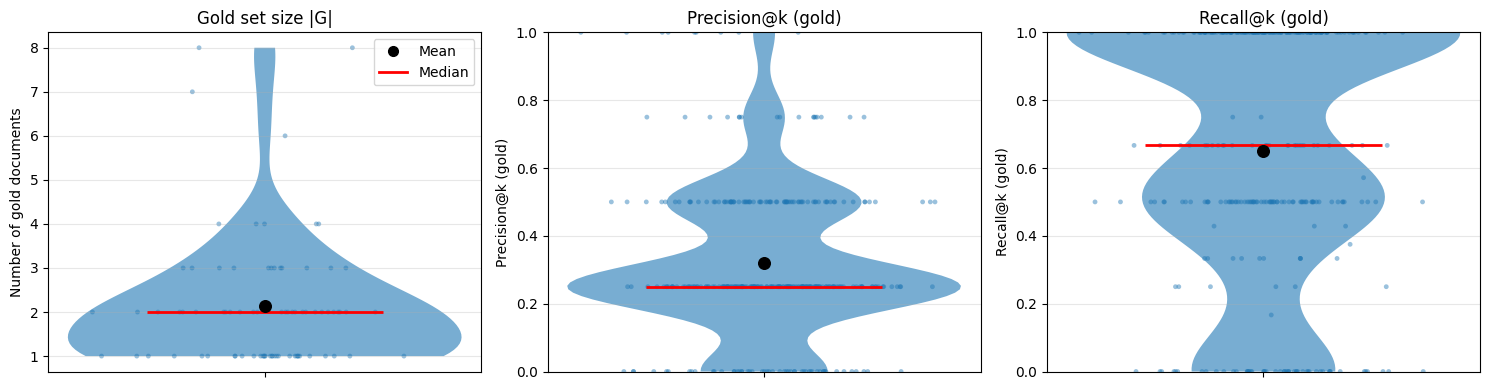

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helper: violin + dots + mean + median
# -----------------------------
def violin_single(
    ax, y, title, ylabel,
    jitter=0.08, dot_size=12,
    dot_color="tab:blue",
    mean_color="black",
    median_color="red"
):
    y = np.asarray(y)
    y = y[~np.isnan(y)]

    vp = ax.violinplot(
        [y],
        positions=[1],
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for body in vp["bodies"]:
        body.set_alpha(0.6)

    # jittered dots
    x_j = np.random.normal(1, jitter, size=len(y))
    ax.scatter(x_j, y, s=dot_size, color=dot_color, alpha=0.45, edgecolors="none")

    # mean + median
    mean_y = np.mean(y)
    median_y = np.median(y)
    ax.scatter(1, mean_y, marker="o", s=70, color=mean_color, zorder=3, label="Mean")
    ax.hlines(median_y, 0.85, 1.15, linewidth=2, color=median_color, label="Median")

    ax.set_xticks([1])
    ax.set_xticklabels([""])
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis="y", alpha=0.3)


# -----------------------------
# Prepare data
# -----------------------------
# Gold size: collapse to unique queries to avoid repetition
gold_q = (
    metrics_df
    .groupby("QID", as_index=False)
    .agg(gold_size=("gold_size", "first"))
)

gold_sizes = gold_q["gold_size"].values
precision_vals = metrics_df["precision@k_goldref"].values
recall_vals = metrics_df["recall@k_goldref"].values

# -----------------------------
# Plot: 3 distributions together
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

violin_single(
    axes[0],
    gold_sizes,
    title="Gold set size |G|",
    ylabel="Number of gold documents"
)

violin_single(
    axes[1],
    precision_vals,
    title="Precision@k (gold)",
    ylabel="Precision@k (gold)"
)
axes[1].set_ylim(0, 1)

violin_single(
    axes[2],
    recall_vals,
    title="Recall@k (gold)",
    ylabel="Recall@k (gold)"
)
axes[2].set_ylim(0, 1)

# shared legend
handles = [
    plt.Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=7, label="Mean"),
    plt.Line2D([0], [0], color="red", linewidth=2, label="Median"),
]
axes[0].legend(handles=handles, loc="upper right")

plt.tight_layout()
plt.show()


In [22]:
recall_vals = metrics_df["recall@k_goldref"].dropna().values

recall_min = recall_vals.min()
recall_max = recall_vals.max()

print(f"Recall@k (gold) ranges from {recall_min:.2f} to {recall_max:.2f}")


Recall@k (gold) ranges from 0.00 to 1.00


## 4 Precision@k (gold) (coarse, bounded)

Nature: Discrete with step 1/k.Upper bound depends on gold size

Summary: Mean precision (reference only) ,Bootstrap CI (Avoid normal-based CI)

Spread :Strip plot / dot plot .Annotate gold size if needed

Visualization:De-emphasize visually (lighter color)

Key question: How clean is the retrieved context relative to annotated gold?

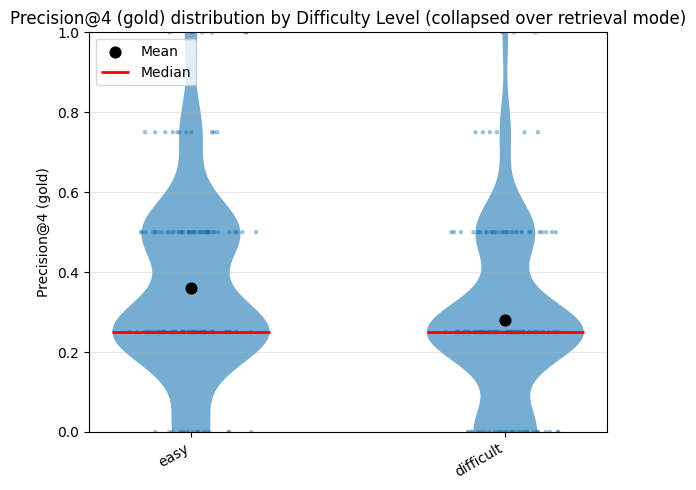

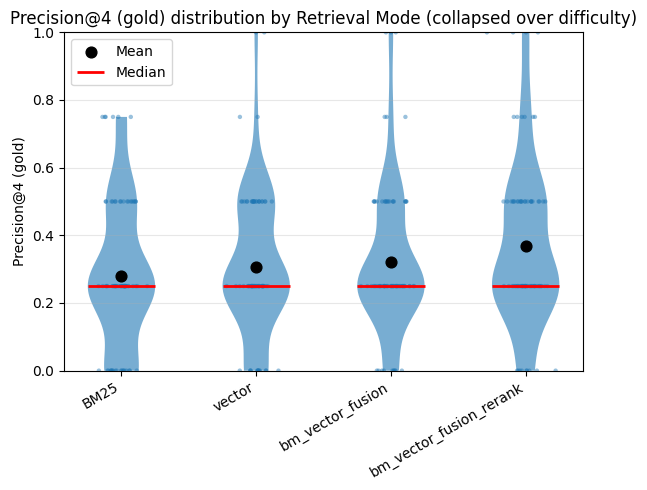

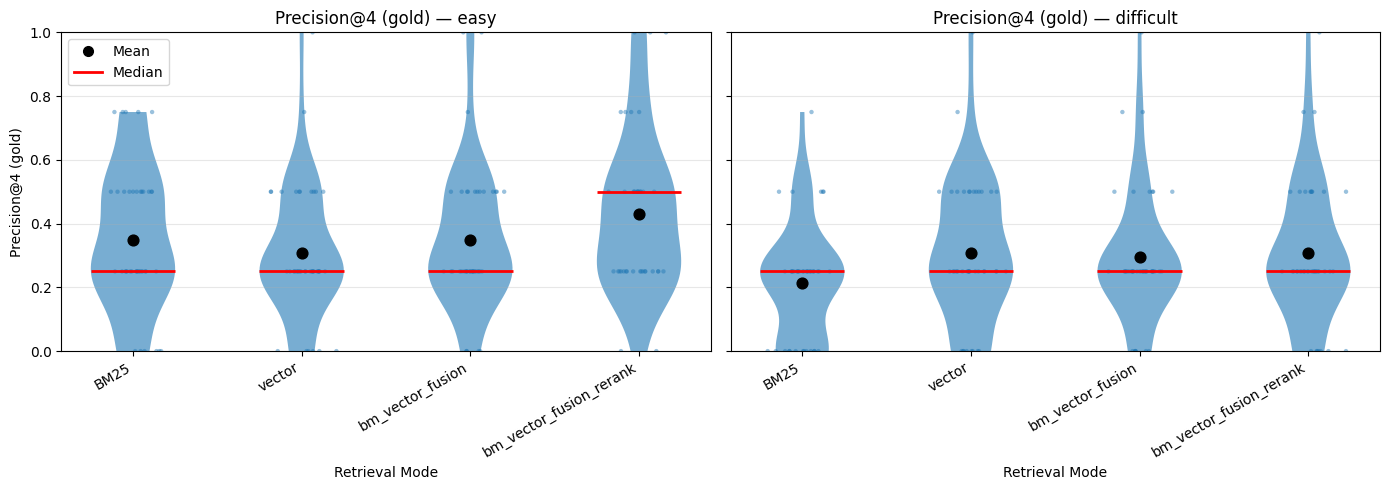

In [23]:
# Precision@k (gold): tables A/B/C with Bootstrap CI + violin (dots/mean/median) + forest plots
# -------------------------------------------------------------------------------------------
# INPUT REQUIRED:
#   metrics_df must contain:
#     - "precision@k_goldref"   (per query×mode; values in {0,0.2,0.4,0.6,0.8,1.0} when k=5)
#     - "Retrieval Mode"
#     - "Difficulty Level"
#
# OUTPUT:
#   - table_A_prec / table_B_prec / table_C_prec
#   - violin plots (A/B/C)
#   - forest plots (A/B/C) with bootstrap CI
#
# NOTE:
# Precision@k (gold) is "gold-referenced context precision"; interpret comparatively (gold may be incomplete).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Canonical ordering (use everywhere)
# -----------------------------
DIFFICULTY_ORDER = ["easy", "difficult"]

MODE_ORDER = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

# -----------------------------
# Violin helper: dots + mean + median (same styling as before)
# -----------------------------
def violin_with_points(
    data_list,
    labels,
    title,
    ylabel="Precision@k (gold)",
    ylim=(0, 1),
    jitter=0.08,
    dot_size=10,
    dot_color="tab:blue",
    median_color="red",
    mean_color="black",
    rotate=30
):
    x = np.arange(1, len(data_list) + 1)

    plt.figure(figsize=(max(6, 1.2 * len(data_list)), 5))

    vp = plt.violinplot(
        data_list,
        positions=x,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for body in vp["bodies"]:
        body.set_alpha(0.6)

    # Jittered dots
    for i, y in enumerate(data_list, start=1):
        y = np.asarray(y)
        y = y[~np.isnan(y)]
        x_j = np.random.normal(i, jitter, size=len(y))
        plt.scatter(x_j, y, s=dot_size, color=dot_color, alpha=0.45, edgecolors="none")

    # Mean + Median
    means = [np.nanmean(y) for y in data_list]
    medians = [np.nanmedian(y) for y in data_list]
    plt.scatter(x, means, marker="o", s=60, color=mean_color, zorder=3, label="Mean")
    plt.hlines(medians, x - 0.25, x + 0.25, linewidth=2, color=median_color, label="Median")

    plt.xticks(x, labels, rotation=rotate, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Prep categories for ordering
# -----------------------------
dfp = metrics_df.copy()
dfp["Difficulty Level"] = pd.Categorical(dfp["Difficulty Level"], categories=DIFFICULTY_ORDER, ordered=True)
dfp["Retrieval Mode"] = pd.Categorical(dfp["Retrieval Mode"], categories=MODE_ORDER, ordered=True)


# Violin A
data_A = [
    dfp.loc[dfp["Difficulty Level"] == diff, "precision@k_goldref"].dropna().values
    for diff in DIFFICULTY_ORDER
]
violin_with_points(
    data_list=data_A,
    labels=DIFFICULTY_ORDER,
    title=f"Precision@{K} (gold) distribution by Difficulty Level (collapsed over retrieval mode)",
    ylabel=f"Precision@{K} (gold)"
)

# Violin B
data_B = [
    dfp.loc[dfp["Retrieval Mode"] == mode, "precision@k_goldref"].dropna().values
    for mode in MODE_ORDER
]
violin_with_points(
    data_list=data_B,
    labels=MODE_ORDER,
    title=f"Precision@{K} (gold) distribution by Retrieval Mode (collapsed over difficulty)",
    ylabel=f"Precision@{K} (gold)"
)

# Violin C: facet by difficulty (two panels)
fig, axes = plt.subplots(1, len(DIFFICULTY_ORDER), figsize=(14, 5), sharey=True)

for ax, diff in zip(axes, DIFFICULTY_ORDER):
    sub = dfp[dfp["Difficulty Level"] == diff]
    data_C = [
        sub.loc[sub["Retrieval Mode"] == mode, "precision@k_goldref"].dropna().values
        for mode in MODE_ORDER
    ]
    x = np.arange(1, len(MODE_ORDER) + 1)

    vp = ax.violinplot(
        data_C,
        positions=x,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for body in vp["bodies"]:
        body.set_alpha(0.6)

    # dots
    for i, yv in enumerate(data_C, start=1):
        yv = np.asarray(yv)
        yv = yv[~np.isnan(yv)]
        x_j = np.random.normal(i, 0.08, size=len(yv))
        ax.scatter(x_j, yv, s=10, color="tab:blue", alpha=0.45, edgecolors="none")

    # mean + median
    means = [np.nanmean(yv) for yv in data_C]
    medians = [np.nanmedian(yv) for yv in data_C]
    ax.scatter(x, means, marker="o", s=60, color="black", zorder=3)
    ax.hlines(medians, x - 0.25, x + 0.25, linewidth=2, color="red")

    ax.set_title(f"Precision@{K} (gold) — {diff}")
    ax.set_xticks(x)
    ax.set_xticklabels(MODE_ORDER, rotation=30, ha="right")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)
    ax.set_xlabel("Retrieval Mode")

axes[0].set_ylabel(f"Precision@{K} (gold)")
handles = [
    plt.Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=7, label="Mean"),
    plt.Line2D([0], [0], color="red", linewidth=2, label="Median"),
]
axes[0].legend(handles=handles, loc="upper left")

plt.tight_layout()
plt.show()



/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3062198343.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3062198343.py:77: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n,mean_precision_gold,boot_low,boot_high,median_precision_gold,q25,q75
Difficulty Level,,,,,,,
easy,160.0,0.359375,0.325000,0.393750,0.25,0.25,0.5
difficult,160.0,0.279687,0.246875,0.314063,0.25,0.25,0.5


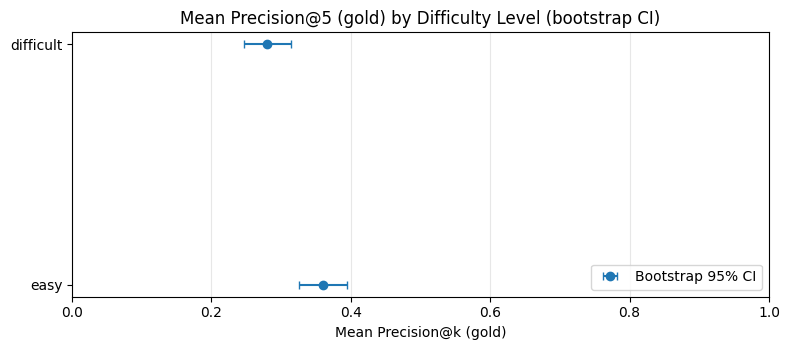

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3062198343.py:94: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3062198343.py:95: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n,mean_precision_gold,boot_low,boot_high,median_precision_gold,q25,q75
Retrieval Mode,,,,,,,
BM25,80.0,0.281250,0.234375,0.331250,0.25,0.25,0.5
vector,80.0,0.306250,0.262500,0.353125,0.25,0.25,0.5
bm_vector_fusion,80.0,0.321875,0.275000,0.371875,0.25,0.25,0.5
bm_vector_fusion_rerank,80.0,0.368750,0.318750,0.421875,0.25,0.25,0.5


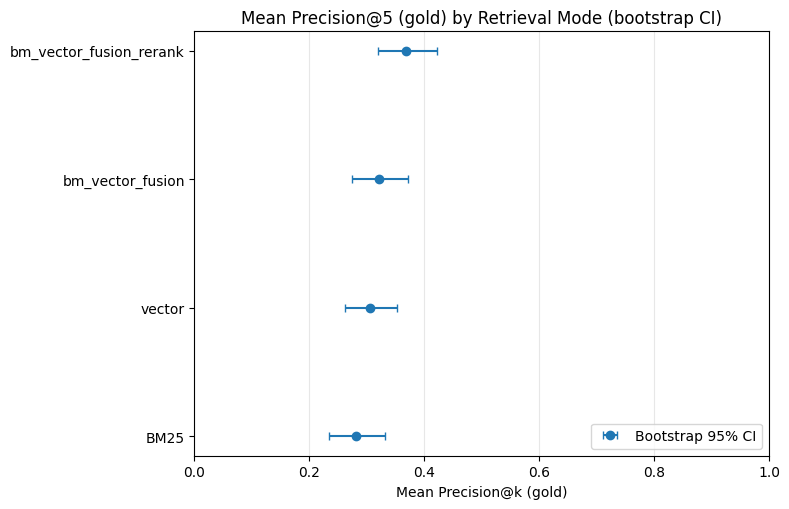

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3062198343.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/3062198343.py:111: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



n  mean_precision_gold  boot_low  \
Difficulty Level Retrieval Mode                                                 
easy             BM25                     40.0              0.35000   0.28125   
                 vector                   40.0              0.30625   0.24375   
                 bm_vector_fusion         40.0              0.35000   0.28125   
                 bm_vector_fusion_rerank  40.0              0.43125   0.35625   
difficult        BM25                     40.0              0.21250   0.15625   
                 vector                   40.0              0.30625   0.23750   
                 bm_vector_fusion         40.0              0.29375   0.23125   
                 bm_vector_fusion_rerank  40.0              0.30625   0.23750   

                                          boot_high  median_precision_gold  \
Difficulty Level Retrieval Mode                                              
easy             BM25                       0.41875                   0.25   
                 vector                     0.36875                   0.25   
                 bm_vector_fusion           0.41875                   0.25   
                 bm_vector_fusion_rerank    0.50625                   0.50   
difficult        BM25                       0.26875                   0.25   
                 vector                     0.37500                   0.25   
                 bm_vector_fusion           0.36250                   0.25   
                 bm_vector_fusion_rerank    0.37500                   0.25   

                                           q25   q75  
Difficulty Level Retrieval Mode                       
easy             BM25                     0.25  0.50  
                 vector                   0.25  0.50  
                 bm_vector_fusion         0.25  0.50  
                 bm_vector_fusion_rerank  0.25  0.50  
difficult        BM25                     0.00  0.25  
                 vector                   0.25  0.50  
                 bm_vector_fusion         0.25  0.25  
                 bm_vector_fusion_rerank  0.25  0.50

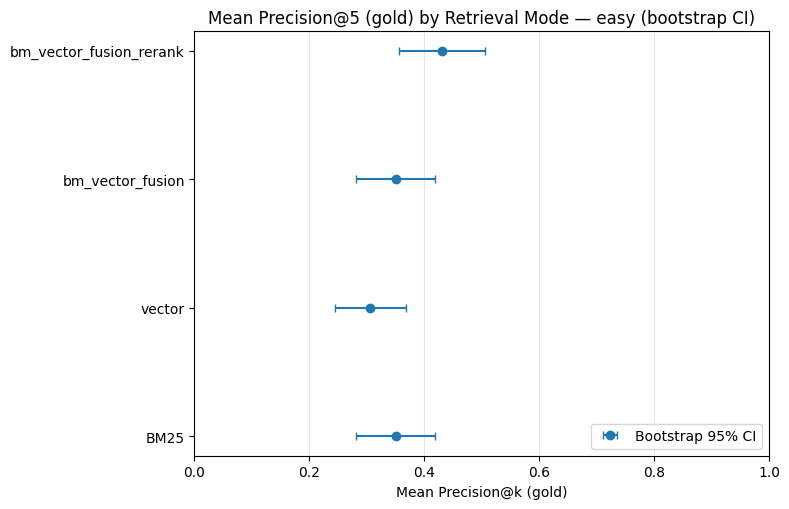

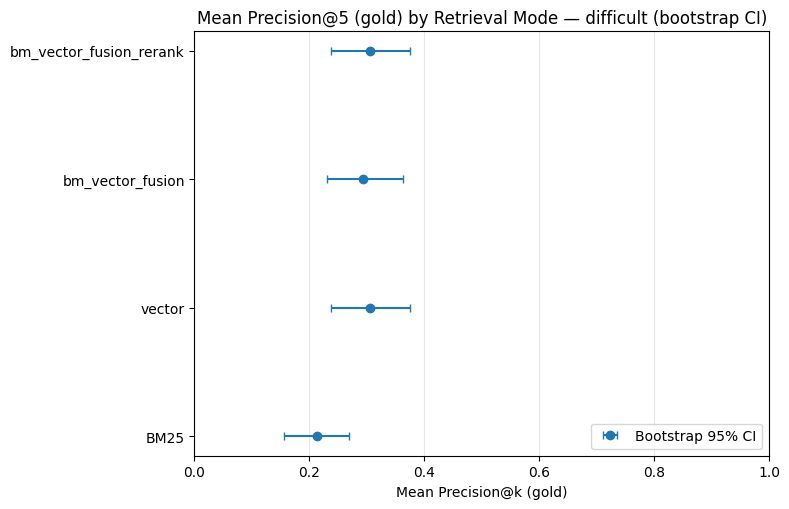

In [24]:

# -----------------------------
# Parameters (explicit)
# -----------------------------
BOOT_B = 10_000
BOOT_ALPHA = 0.05   # 95% CI
K = 5               # top-k used in retrieval, informational here

# -----------------------------
# Bootstrap CI for the mean
# -----------------------------
def bootstrap_ci_mean(x, B=BOOT_B, alpha=BOOT_ALPHA, random_state=0):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan

    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(B)]
    low = np.percentile(boot_means, 100 * alpha / 2)
    high = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return float(np.mean(x)), float(low), float(high)


# -----------------------------
# Summarize per group
# -----------------------------
def summarize_precision_gold(group, seed=0):
    x = group["precision@k_goldref"].dropna().values
    mean_p, low, high = bootstrap_ci_mean(x, random_state=seed)
    return pd.Series({
        "n": len(x),
        "mean_precision_gold": mean_p,
        "boot_low": low,
        "boot_high": high,
        "median_precision_gold": float(np.median(x)) if len(x) else np.nan,
        "q25": float(np.quantile(x, 0.25)) if len(x) else np.nan,
        "q75": float(np.quantile(x, 0.75)) if len(x) else np.nan,
    })


# -----------------------------
# Forest plot: bootstrap CI only (no Bayesian for precision@k gold here)
# -----------------------------
def forest_plot_bootstrap(table, title, mean_col="mean_precision_gold"):
    y = np.arange(len(table))

    plt.figure(figsize=(8, 0.8 * len(table) + 2))

    plt.errorbar(
        table[mean_col],
        y,
        xerr=[
            table[mean_col] - table["boot_low"],
            table["boot_high"] - table[mean_col]
        ],
        fmt="o",
        capsize=3,
        label=f"Bootstrap {int((1-BOOT_ALPHA)*100)}% CI"
    )

    plt.yticks(y, table.index)
    plt.xlabel("Mean Precision@k (gold)")
    plt.title(title)
    plt.xlim(0, 1)
    plt.grid(axis="x", alpha=0.3)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# ============================================================
# (A) By difficulty level (collapse over retrieval mode)
# ============================================================
table_A_prec = (
    dfp
    .groupby("Difficulty Level")
    .apply(lambda g: summarize_precision_gold(g, seed=10))
    .reindex(DIFFICULTY_ORDER)
)
display(table_A_prec)


# Forest A
forest_plot_bootstrap(
    table_A_prec,
    title=f"Mean Precision@{K} (gold) by Difficulty Level (bootstrap CI)"
)

# ============================================================
# (B) By retrieval mode (collapse over difficulty)
# ============================================================
table_B_prec = (
    dfp
    .groupby("Retrieval Mode")
    .apply(lambda g: summarize_precision_gold(g, seed=20))
    .reindex(MODE_ORDER)
)
display(table_B_prec)

# Forest B
forest_plot_bootstrap(
    table_B_prec,
    title=f"Mean Precision@{K} (gold) by Retrieval Mode (bootstrap CI)"
)
# ============================================================
# (C) Interaction: retrieval mode × difficulty (facet by difficulty)
# ============================================================
table_C_prec = (
    dfp
    .groupby(["Difficulty Level", "Retrieval Mode"])
    .apply(lambda g: summarize_precision_gold(g, seed=30))
    .reindex(
        pd.MultiIndex.from_product(
            [DIFFICULTY_ORDER, MODE_ORDER],
            names=["Difficulty Level", "Retrieval Mode"]
        )
    )
)
display(table_C_prec)


# Forest C: one forest plot per difficulty (clean)
for diff in DIFFICULTY_ORDER:
    sub = table_C_prec.loc[diff]
    forest_plot_bootstrap(
        sub,
        title=f"Mean Precision@{K} (gold) by Retrieval Mode — {diff} (bootstrap CI)"
    )


## 5 Recall@k (gold) (heterogeneous)

Recall@k was computed relative to the annotated gold set and is therefore interpreted as a measure of gold coverage rather than true recall. Due to heterogeneous gold set sizes and incomplete relevance judgments, Recall@k is reported descriptively alongside gold-size distributions. Group-level uncertainty was quantified using nonparametric bootstrap confidence intervals for the mean.

Nature :Bounded [0,1],Depends on gold size

Summary: Mean recall (descriptive),Bootstrap CI 

Spread:violin,Consider stratifying by gold size

Visualization: Supplementary figure

Key question:How much of the annotated gold set is covered?

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BOOT_B = 10_000
BOOT_ALPHA = 0.05
K = 5

def bootstrap_ci_mean(x, B=BOOT_B, alpha=BOOT_ALPHA, random_state=0):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan

    boot_means = [
        np.mean(rng.choice(x, size=n, replace=True))
        for _ in range(B)
    ]
    low = np.percentile(boot_means, 100 * alpha / 2)
    high = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return float(np.mean(x)), float(low), float(high)

def summarize_recall_gold(group, seed=0):
    x = group["recall@k_goldref"].dropna().values
    mean_r, low, high = bootstrap_ci_mean(x, random_state=seed)
    return pd.Series({
        "n": len(x),
        "mean_recall_gold": mean_r,
        "boot_low": low,
        "boot_high": high,
        "median_recall_gold": float(np.median(x)) if len(x) else np.nan,
        "q25": float(np.quantile(x, 0.25)) if len(x) else np.nan,
        "q75": float(np.quantile(x, 0.75)) if len(x) else np.nan,
    })
def violin_with_points(
    data_list, labels, title, ylabel,
    jitter=0.08, dot_size=10,
    mean_color="black", median_color="red"
):
    x = np.arange(1, len(data_list) + 1)

    plt.figure(figsize=(max(6, 1.2 * len(data_list)), 5))

    vp = plt.violinplot(
        data_list, positions=x,
        showmeans=False, showmedians=False, showextrema=False
    )
    for body in vp["bodies"]:
        body.set_alpha(0.6)

    for i, y in enumerate(data_list, start=1):
        y = np.asarray(y)
        y = y[~np.isnan(y)]
        x_j = np.random.normal(i, jitter, size=len(y))
        plt.scatter(x_j, y, s=dot_size, alpha=0.45)

    means = [np.nanmean(y) for y in data_list]
    medians = [np.nanmedian(y) for y in data_list]
    plt.scatter(x, means, s=60, color=mean_color, label="Mean", zorder=3)
    plt.hlines(medians, x - 0.25, x + 0.25, color=median_color, lw=2, label="Median")

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


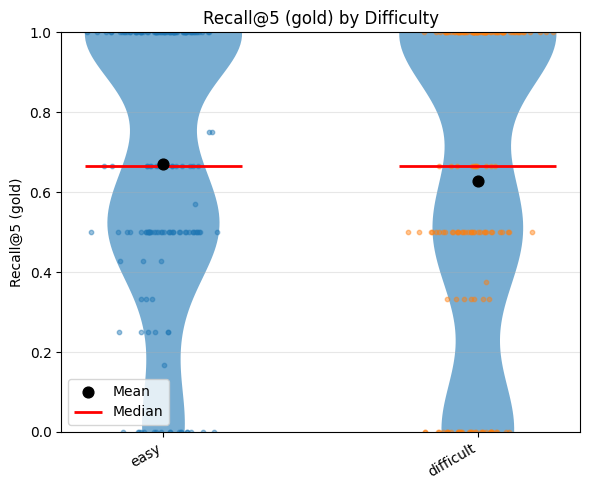

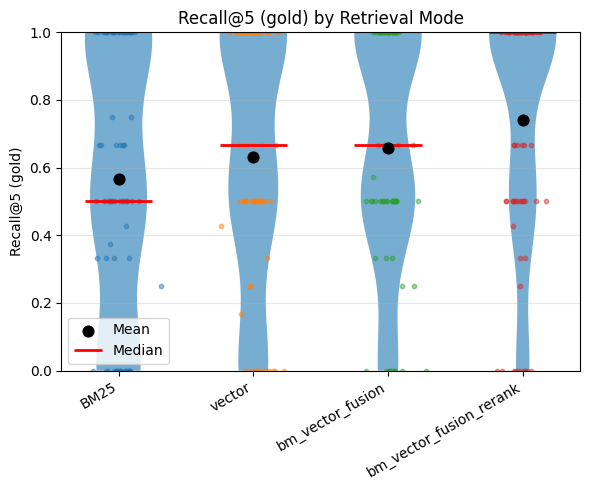

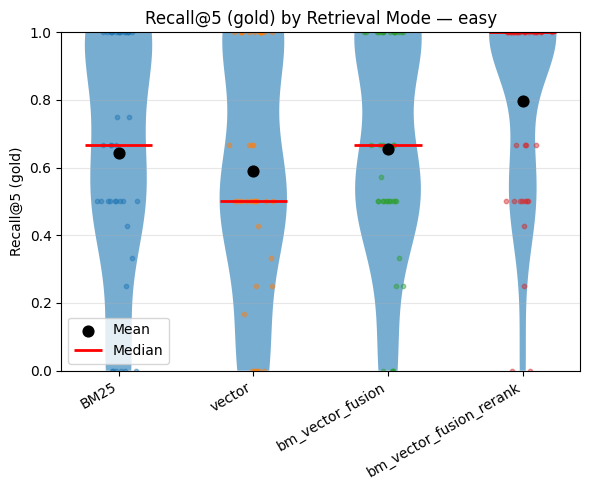

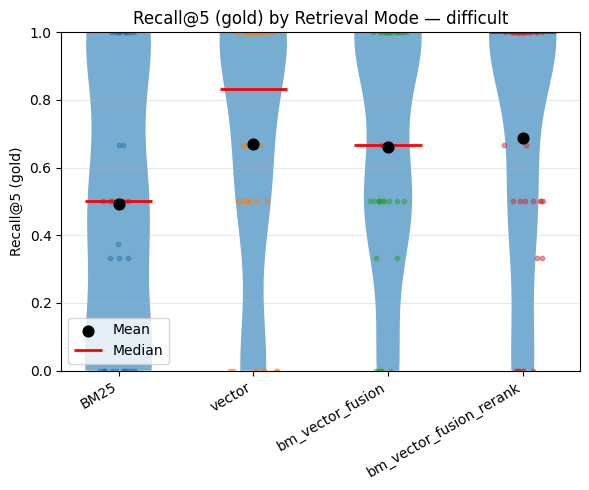

In [26]:
data_A = [
    metrics_df.loc[metrics_df["Difficulty Level"] == d, "recall@k_goldref"].values
    for d in DIFFICULTY_ORDER
]

violin_with_points(
    data_A,
    DIFFICULTY_ORDER,
    title=f"Recall@{K} (gold) by Difficulty",
    ylabel=f"Recall@{K} (gold)"
)

data_B = [
    metrics_df.loc[metrics_df["Retrieval Mode"] == m, "recall@k_goldref"].values
    for m in MODE_ORDER
]

violin_with_points(
    data_B,
    MODE_ORDER,
    title=f"Recall@{K} (gold) by Retrieval Mode",
    ylabel=f"Recall@{K} (gold)"
)

for diff in DIFFICULTY_ORDER:
    data_C = [
        metrics_df.loc[
            (metrics_df["Difficulty Level"] == diff) &
            (metrics_df["Retrieval Mode"] == m),
            "recall@k_goldref"
        ].values
        for m in MODE_ORDER
    ]

    violin_with_points(
        data_C,
        MODE_ORDER,
        title=f"Recall@{K} (gold) by Retrieval Mode — {diff}",
        ylabel=f"Recall@{K} (gold)"
    )


In [27]:
table_A_rec = (
    metrics_df
    .groupby("Difficulty Level")
    .apply(lambda g: summarize_recall_gold(g, seed=1))
    .reindex(DIFFICULTY_ORDER)
)

table_B_rec = (
    metrics_df
    .groupby("Retrieval Mode")
    .apply(lambda g: summarize_recall_gold(g, seed=2))
    .reindex(MODE_ORDER)
)

table_C_rec = (
    metrics_df
    .groupby(["Difficulty Level", "Retrieval Mode"])
    .apply(lambda g: summarize_recall_gold(g, seed=3))
)

display(table_A_rec)
display(table_B_rec)
display(table_C_rec)


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2892011557.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2892011557.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_11979/2892011557.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

,n,mean_recall_gold,boot_low,boot_high,median_recall_gold,q25,q75
Difficulty Level,,,,,,,
easy,160.0,0.670982,0.616888,0.723586,0.666667,0.500000,1.0
difficult,160.0,0.628385,0.566667,0.689063,0.666667,0.333333,1.0


,n,mean_recall_gold,boot_low,boot_high,median_recall_gold,q25,q75
Retrieval Mode,,,,,,,
BM25,80.0,0.567336,0.482586,0.651042,0.500000,0.3125,1.0
vector,80.0,0.630357,0.547024,0.711458,0.666667,0.5000,1.0
bm_vector_fusion,80.0,0.659226,0.581250,0.735119,0.666667,0.5000,1.0
bm_vector_fusion_rerank,80.0,0.741815,0.665625,0.815774,1.000000,0.5000,1.0


n  mean_recall_gold  boot_low  \
Difficulty Level Retrieval Mode                                              
easy             BM25                     40.0          0.641964  0.529457   
                 vector                   40.0          0.589881  0.477381   
                 bm_vector_fusion         40.0          0.655952  0.554167   
                 bm_vector_fusion_rerank  40.0          0.796131  0.700298   
difficult        BM25                     40.0          0.492708  0.366667   
                 vector                   40.0          0.670833  0.550000   
                 bm_vector_fusion         40.0          0.662500  0.550000   
                 bm_vector_fusion_rerank  40.0          0.687500  0.566667   

                                          boot_high  median_recall_gold  \
Difficulty Level Retrieval Mode                                           
easy             BM25                      0.750298            0.666667   
                 vector                    0.702083            0.500000   
                 bm_vector_fusion          0.754204            0.666667   
                 bm_vector_fusion_rerank   0.881250            1.000000   
difficult        BM25                      0.620833            0.500000   
                 vector                    0.783333            0.833333   
                 bm_vector_fusion          0.770833            0.666667   
                 bm_vector_fusion_rerank   0.804167            1.000000   

                                               q25  q75  
Difficulty Level Retrieval Mode                          
easy             BM25                     0.500000  1.0  
                 vector                   0.404762  1.0  
                 bm_vector_fusion         0.500000  1.0  
                 bm_vector_fusion_rerank  0.500000  1.0  
difficult        BM25                     0.000000  1.0  
                 vector                   0.500000  1.0  
                 bm_vector_fusion         0.500000  1.0  
                 bm_vector_fusion_rerank  0.500000  1.0

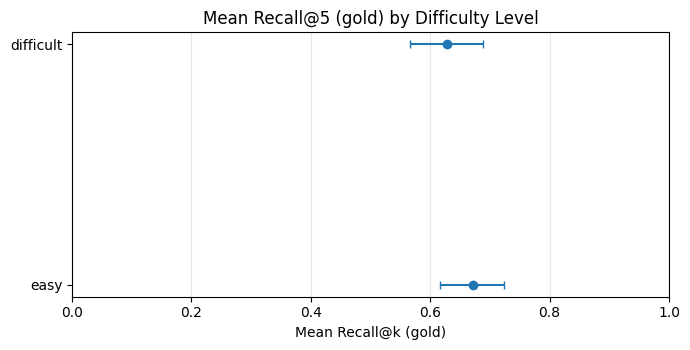

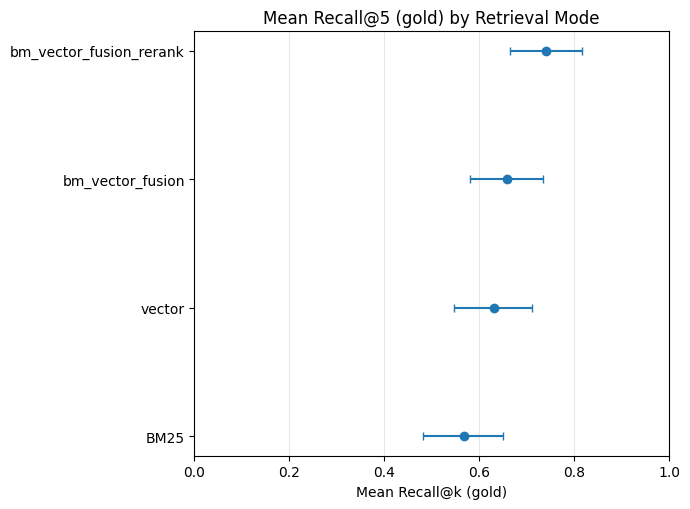

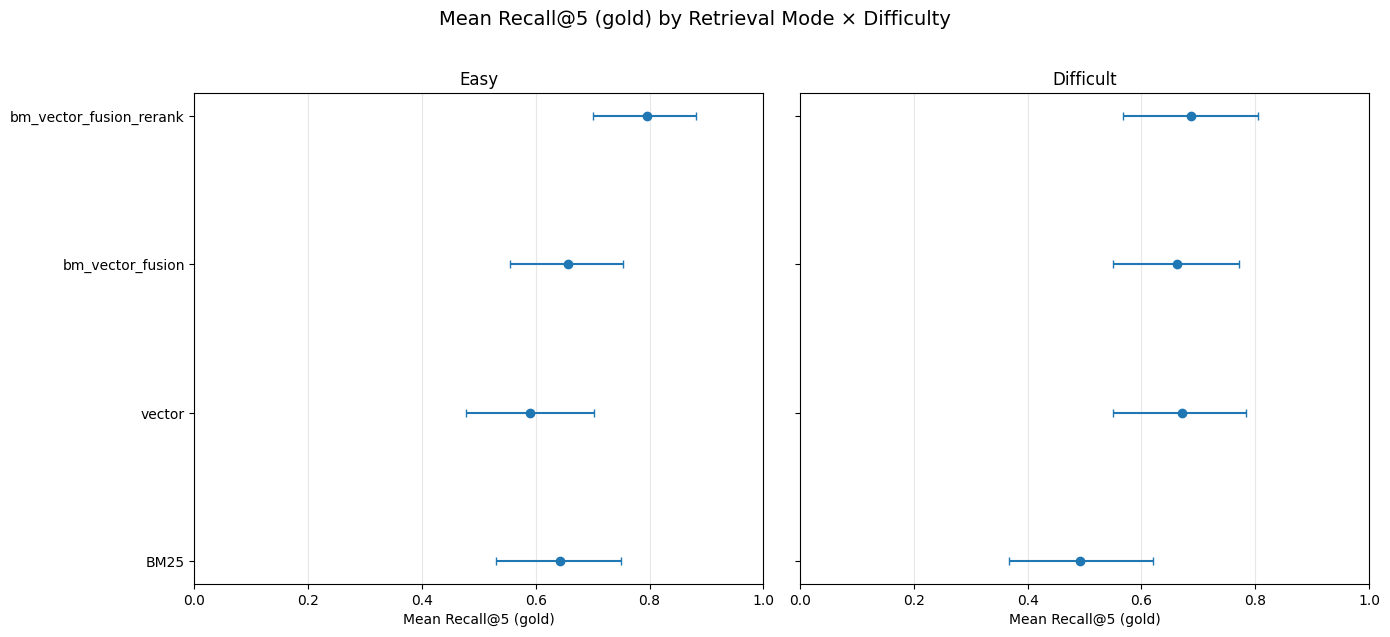

In [28]:
def forest_plot_bootstrap(table, mean_col, title):
    y = np.arange(len(table))

    plt.figure(figsize=(7, 0.8 * len(table) + 2))
    plt.errorbar(
        table[mean_col], y,
        xerr=[
            table[mean_col] - table["boot_low"],
            table["boot_high"] - table[mean_col]
        ],
        fmt="o", capsize=3
    )
    plt.yticks(y, table.index)
    plt.xlabel("Mean Recall@k (gold)")
    plt.title(title)
    plt.xlim(0, 1)
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

forest_plot_bootstrap(
    table_A_rec,
    "mean_recall_gold",
    f"Mean Recall@{K} (gold) by Difficulty Level"
)

forest_plot_bootstrap(
    table_B_rec,
    "mean_recall_gold",
    f"Mean Recall@{K} (gold) by Retrieval Mode"
)

# Interaction forest plots: one per difficulty level
def forest_plot_bootstrap_ax(ax, table, mean_col, title, xlabel):
    y = np.arange(len(table))

    ax.errorbar(
        table[mean_col], y,
        xerr=[
            table[mean_col] - table["boot_low"],
            table["boot_high"] - table[mean_col]
        ],
        fmt="o", capsize=3
    )

    ax.set_yticks(y)
    ax.set_yticklabels(table.index)
    ax.set_xlim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(axis="x", alpha=0.3)


# -----------------------------
# Side-by-side plots
# -----------------------------
fig, axes = plt.subplots(
    1, len(DIFFICULTY_ORDER),
    figsize=(14, 0.8 * len(MODE_ORDER) + 3),
    sharex=True,
    sharey=True
)

for ax, diff in zip(axes, DIFFICULTY_ORDER):
    forest_plot_bootstrap_ax(
        ax,
        table_C_rec.loc[diff],   # slice MultiIndex
        mean_col="mean_recall_gold",
        title=f"{diff.capitalize()}",
        xlabel=f"Mean Recall@{K} (gold)"
    )

fig.suptitle(
    f"Mean Recall@{K} (gold) by Retrieval Mode × Difficulty",
    fontsize=14,
    y=1.02
)

plt.tight_layout()
plt.show()





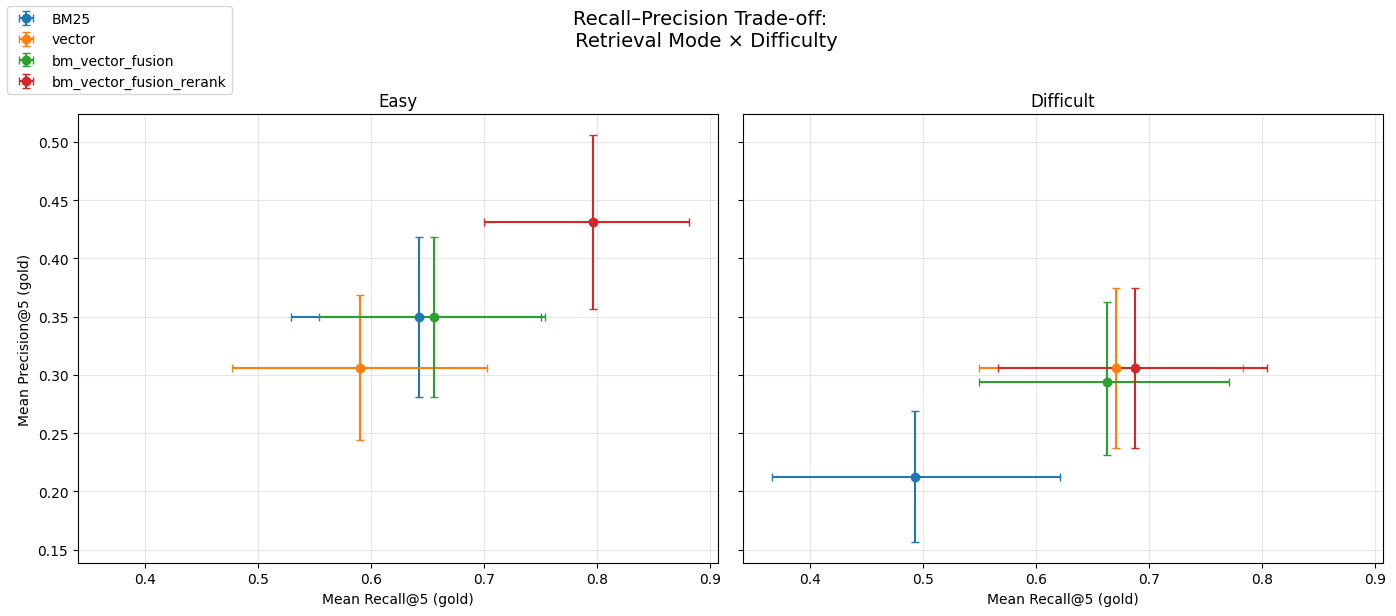

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    1, len(DIFFICULTY_ORDER),
    figsize=(14, 6),
    sharex=True,
    sharey=True
)

for ax, diff in zip(axes, DIFFICULTY_ORDER):
    for mode in MODE_ORDER:
        r = table_C_rec.loc[(diff, mode)]
        p = table_C_prec.loc[(diff, mode)]

        ax.errorbar(
            r["mean_recall_gold"],
            p["mean_precision_gold"],
            xerr=[[r["mean_recall_gold"] - r["boot_low"]],
                  [r["boot_high"] - r["mean_recall_gold"]]],
            yerr=[[p["mean_precision_gold"] - p["boot_low"]],
                  [p["boot_high"] - p["mean_precision_gold"]]],
            fmt="o",
            capsize=3,
            label=mode
        )

    ax.set_title(diff.capitalize())
    ax.set_xlabel(f"Mean Recall@{K} (gold)")
    ax.grid(alpha=0.3)

axes[0].set_ylabel(f"Mean Precision@{K} (gold)")

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper left",
    ncol=1,
    frameon=True
)

fig.suptitle(
    f"Recall–Precision Trade-off: \n Retrieval Mode × Difficulty",
    fontsize=14,
    y=1.02
)

plt.tight_layout()
plt.show()
